In [2]:
%load_ext autoreload
%autoreload 2
from utils import *
from IPython.display import display, HTML

In [7]:
def getINFO(info_string):
        infolist = info_string.split(';')
        infodict = {}
        for kv in infolist:
                kv = kv.split('=')
                if len(kv) == 2:
                        k, v = kv
                        infodict[k] = v 
        return infodict

def match_allele_csq(Ref, Alts, csq_head, csq_string):
        # Trim Leading Base
        Alts = Alts.split(",")
        if len(list(set([x[0] for x in Alts])))==1 and Ref[0] == list(set([x[0] for x in Alts]))[0]:
                _Ref = Ref[1:] if len(Ref[1:]) >0 else "-" 
                _Alts = [Alt[1:] if len(Alt[1:]) >0 else "-" for Alt in Alts]
        else:
                _Alts = Alts
        res = {}
        csqs = csq_string.split(",")
        csqs = [dict(zip(csq_head, vep.split("|"))) for vep in csqs]
        for i, Alt in enumerate(Alts):
                res[Alt] = []
                for j, csq in enumerate(csqs):
                        if csq["Allele"] == _Alts[i]:
                                csq["Consequence"] = csq["Consequence"] .split("&")
                                res[Alt].append(csq)
        return res

Genes = ["ASXL3","CHD2","CHD8","DSCAM","DYRK1A","FOXP1","HIVEP2","SCN2A"]
def GetRelventCSQ(CSQs):
    for csq in CSQs:
        if csq["SYMBOL"] in Genes:
            return csq

In [16]:
LGD_class = set(["splice_acceptor_variant", "splice_donor_variant", "stop_gained",
                "stop_lost", "start_lost", "frameshift_variant"])

VCF = "/Users/jiayao/Work/BrainDisorders/src/unifiedmodel/VIP.RecGenes.VEP.vcf"
hand = open(VCF, 'rt')
outfil = csv.writer(open("VIP.RecGenes.tsv", 'wt'), delimiter="\t")
outfil.writerow(["Chr", "Pos", "ref", "Alt", "Gene", "cons", "AF", "sample", "GT"])
for l in hand:
    if l.startswith("##"):
        if l.startswith("##INFO=<ID=CSQ"):
            CSQ_header = l.strip().split("Format: ")[1].rstrip('>\"').split("|")
        continue
    elif l.startswith("#C"):
        header = l.strip().split("\t")
        samples = header[9:]
        continue
    llist = l.strip().split("\t")
    genotypes = llist[9:]
    #if llist[6] != "PASS":
    #    continue
    Chr, Pos, ID, ref, alts = llist[0:5]
    INFO_string = llist[7]
    infodict = getINFO(llist[7])
    Allele_CSQ_dict = match_allele_csq(ref, alts, CSQ_header, infodict["CSQ"])
    for i,Alt in enumerate(alts.split(',')):
        vep = GetRelventCSQ(Allele_CSQ_dict[Alt])
        cons = vep["Consequence"]
        AF = vep["gnomAD_AF"]
        Gene = vep["SYMBOL"]
        if len(set(cons).intersection(LGD_class))>= 1:
            for j, GT in enumerate(genotypes):
                gt = GT.split(":")[0].split("/")
                if int(gt[1]) == i+1:
                    sample = samples[j]
                    outfil.writerow([Chr, Pos, ref, Alt, Gene, cons, AF, sample, GT])

In [409]:
# VABS, VIQ, NVIQ
VABS_df = pd.read_csv("/Users/jiayao/Work/BrainDisorders/VIP_phenotype/SSC_PhenotypeV15.2/Proband_Data/ssc_proband_vineland_ii.csv")
VABS_df.head()
scores = VABS_df["composite_standard_score"].values
fams = VABS_df["individual"].values
fams = [int(x.split(".")[0]) for x in fams]
indv2vabs = dict(zip(fams, scores))
core_desc = pd.read_csv(
    "/Users/jiayao/Work/BrainDisorders/VIP_phenotype/SSC_PhenotypeV15.2/Proband_Data/ssc_core_descriptive.csv")
core_desc = core_desc[["individual", "ssc_diagnosis_full_scale_iq",
                       "ssc_diagnosis_nonverbal_iq", "ssc_diagnosis_verbal_iq"]]
core_desc["familyId"] = core_desc.apply(lambda row:int(row["individual"].split(".")[0]), axis=1)
#display(core_desc.head(2))
core_desc.columns.values
famID2FSIQ = dict(zip(core_desc["familyId"].values, core_desc["ssc_diagnosis_full_scale_iq"].values))


In [358]:
LGD_DF = pd.read_excel("/Users/jiayao/Work/BrainDisorders/data/DenovoVariants/wigler2014ProLGD.xlsx")
LGD_fams = set(LGD_DF["familyId"].values)

In [1190]:
wigler_fam_info = pd.read_excel("/Users/jiayao/Work/BrainDisorders/data/nature13908-s2/Supplementary_Table_1.xlsx")
#wigler_fam_info = wigler_fam_info[wigler_fam_info["familyId"].isin(LGD_fams)]
wigler_fam_info["VIQ"] = wigler_fam_info["probandVIQ"]
wigler_fam_info["NVIQ"] = wigler_fam_info["probandNVIQ"]
wigler_fam_info = wigler_fam_info[["familyId", "VIQ", "NVIQ"]]
wigler_fam_info["VABS"] = wigler_fam_info.apply(lambda row:indv2vabs.get(row["familyId"], np.nan), axis=1)
wigler_fam_info["FSIQ"] = wigler_fam_info.apply(lambda row:famID2FSIQ.get(row["familyId"], np.nan), axis=1)
wigler_fam_info = wigler_fam_info.dropna(axis=0)
wigler_fam_info.head()

,familyId,VIQ,NVIQ,VABS,FSIQ
0,11542,121.0,102.0,82.0,109.0
1,13736,119.0,112.0,82.0,118.0
2,13735,30.0,27.0,59.0,28.0
3,13734,36.0,51.0,60.0,43.0
4,11546,100.0,123.0,76.0,99.0


In [1158]:
#SameExonIQ
Jiayao_features = pd.read_csv("unifiedmodel/features.jiayao.65.csv")
#Jiayao_features = pd.read_csv("unifiedmodel/SSC.LGD.features.csv")
Jiayao_features = Jiayao_features.dropna()
#Jiayao_features["VABS"] = Jiayao_features.apply(lambda row:indv2vabs.get(row["familyId"], np.nan), axis=1)
ExonCount = Jiayao_features.groupby("ExonID")["ExonID"].count()
Jiayao_features["ExonCount"] = Jiayao_features.apply(lambda row: ExonCount[row["ExonID"]], axis=1)
SameExon = Jiayao_features[Jiayao_features["ExonCount"]>=2]
SameExonFSIQ_diff, SameExonVIQ_diff, SameExonNVIQ_diff, SameExonVABS_diff = [], [], [], []
for exon in list(set(SameExon['ExonID'].values)):
    tmpdf = SameExon[SameExon["ExonID"]==exon]
    FSIQs = tmpdf["FSIQ"].values
    VIQs = tmpdf["VIQ"].values
    NVIQs = tmpdf["NVIQ"].values
    VABSs = tmpdf["VABS"].values
    SameExonFSIQ_diff.append(abs(FSIQs[0]-FSIQs[1]))
    SameExonVIQ_diff.append(abs(VIQs[0]-VIQs[1]))
    SameExonNVIQ_diff.append(abs(NVIQs[0]-NVIQs[1]))
    SameExonVABS_diff.append(abs(VABSs[0]-VABSs[1]))

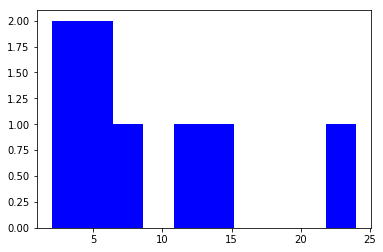

8.875 17.25 8.25 6.875
[2.0, 5.0, 13.0, 6.0, 2.0, 12.0, 7.0, 24.0]


In [1159]:
plt.hist(SameExonFSIQ_diff, color="b")
plt.show()
print(np.mean(SameExonFSIQ_diff), np.mean(SameExonVIQ_diff), np.mean(SameExonNVIQ_diff), np.mean(SameExonVABS_diff))
print(SameExonFSIQ_diff)

In [1194]:
#spearmanr
print("FSIQ - NVIQ", pearsonr(Jiayao_features["FSIQ"].values, Jiayao_features["NVIQ"].values))
print("NVIQ - VIQ", pearsonr(Jiayao_features["NVIQ"].values, Jiayao_features["VIQ"].values))
print("FSIQ - VIQ", pearsonr(Jiayao_features["FSIQ"].values, Jiayao_features["VIQ"].values))
print("NVIQ - VABS", pearsonr(Jiayao_features["NVIQ"].values, Jiayao_features["VABS"].values))
print("VIQ - VABS", pearsonr(Jiayao_features["VIQ"].values, Jiayao_features["VABS"].values))

FSIQ - NVIQ (0.9083195285498538, 3.7591763153557934e-25)
NVIQ - VIQ (0.8225750753782097, 7.697198327726727e-17)
FSIQ - VIQ (0.8840636996968843, 3.753169776359777e-22)
NVIQ - VABS (0.45643524692875503, 0.00015017238970429407)
VIQ - VABS (0.50827108817764, 1.8052603790983183e-05)


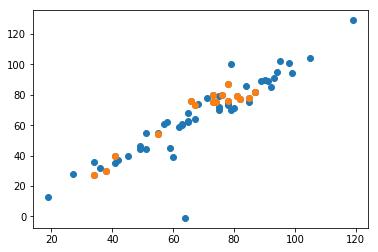

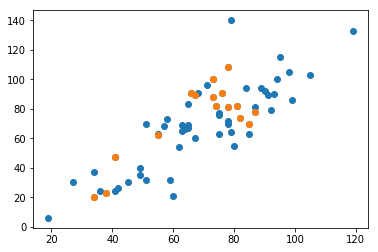

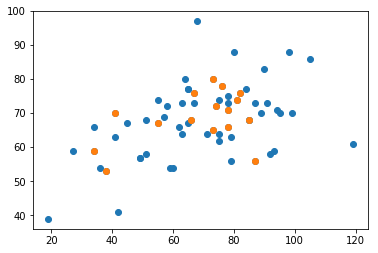

In [453]:
plt.scatter(Jiayao_features["NVIQ"].values, Jiayao_features["FSIQ"].values)
plt.scatter(SameExon["NVIQ"].values, SameExon["FSIQ"].values)
plt.show()
plt.scatter(Jiayao_features["NVIQ"].values, Jiayao_features["VIQ"].values)
plt.scatter(SameExon["NVIQ"].values, SameExon["VIQ"].values)
plt.show()
plt.scatter(Jiayao_features["NVIQ"].values, Jiayao_features["VABS"].values)
plt.scatter(SameExon["NVIQ"].values, SameExon["VABS"].values)
plt.show()

In [1195]:
print("NVIQ - VIQ", pearsonr(wigler_fam_info["NVIQ"].values, wigler_fam_info["VIQ"].values))
print("NVIQ - VABS", pearsonr(wigler_fam_info["NVIQ"].values, wigler_fam_info["VABS"].values))
print("VIQ - VABS", pearsonr(wigler_fam_info["VIQ"].values, wigler_fam_info["VABS"].values))

NVIQ - VIQ (0.8373403405594042, 0.0)
NVIQ - VABS (0.6693201580849893, 8.17618e-318)
VIQ - VABS (0.6616512007654329, 4.417303093332454e-308)


In [456]:
import itertools
ALL_FSIQ_diff = []
ALL_VIQ_diff = []
ALL_NVIQ_diff = []
ALL_VABS_diff = []
SE_FSIQ_diff = []
SE_VIQ_diff = []
SE_NVIQ_diff = []
SE_VABS_diff = []
for row1, row2 in itertools.combinations(Jiayao_features.iterrows(), r=2):
    row1 = row1[1]
    row2 = row2[1]
    FSIQ_diff = abs(row1["FSIQ"]- row2["FSIQ"])
    NVIQ_diff = abs(row1["NVIQ"]- row2["NVIQ"])
    VIQ_diff = abs(row1["VIQ"]- row2["VIQ"])
    VABS_diff = abs(row1["VABS"]- row2["VABS"])
    if row1["ExonID"] == row2["ExonID"]:
        SE_FSIQ_diff.append(FSIQ_diff)
        SE_VIQ_diff.append(VIQ_diff)
        SE_NVIQ_diff.append(NVIQ_diff)
        SE_VABS_diff.append(VABS_diff)
    else:
        ALL_FSIQ_diff.append(FSIQ_diff)
        ALL_VIQ_diff.append(VIQ_diff)
        ALL_NVIQ_diff.append(NVIQ_diff)
        ALL_VABS_diff.append(VABS_diff)

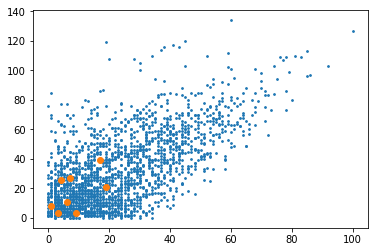

In [460]:
plt.scatter(ALL_NVIQ_diff, ALL_VIQ_diff, s=3)
plt.scatter(SE_NVIQ_diff, SE_VIQ_diff)
plt.show()

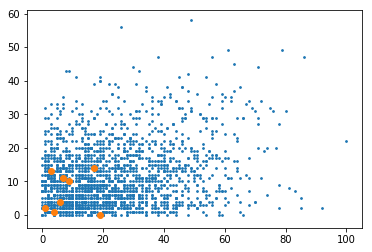

In [461]:
plt.scatter(ALL_NVIQ_diff, ALL_VABS_diff, s=3)
plt.scatter(SE_NVIQ_diff, SE_VABS_diff)
plt.show()

In [1126]:
class NVIQ_VABS_PAIR:
    def __init__(self, NVIQ_DIFF, VABS_DIFF):
        self.NVIQ_DIFF = NVIQ_DIFF
        self.VABS_DIFF = VABS_DIFF
ALL_NVIQ_VABS_Pairs = [NVIQ_VABS_PAIR(x,y) for x,y in zip(ALL_NVIQ_diff, ALL_VABS_diff)]
ALL_NVIQ_VIQ_Pairs = [NVIQ_VABS_PAIR(x,y) for x,y in zip(ALL_NVIQ_diff, ALL_VIQ_diff)]

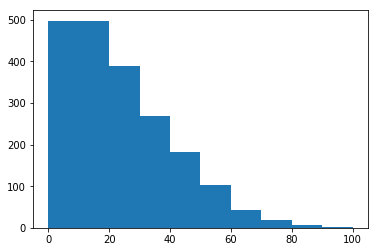

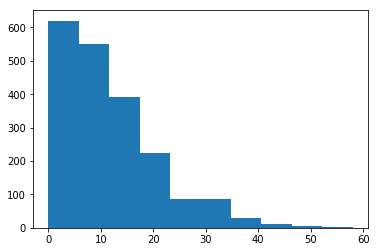

In [1142]:
plt.hist(ALL_NVIQ_diff)
plt.show()
plt.hist(ALL_VABS_diff)
plt.show()

In [1103]:
VIQRatios, SelectedSamples_VIQ_NVIQ = RatioPermutationTest(ALL_NVIQ_VABS_Pairs, Npermute=100)

In [1115]:
NVIQ_mean, VABS_mean, NVIQ_mean_, VABS_mean_ = [], [], [], []
for sp in SelectedSamples_VIQ_NVIQ:
    First8 = sp[:8]
    Last60 = sp[8:]
    NVIQ_mean.append(np.mean([x.NVIQ_DIFF for x in First8]))
    VABS_mean.append(np.mean([x.VABS_DIFF for x in First8]))
    NVIQ_mean_.append(np.mean([x.NVIQ_DIFF for x in Last60]))
    VABS_mean_.append(np.mean([x.VABS_DIFF for x in Last60]))

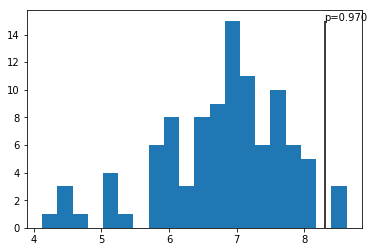

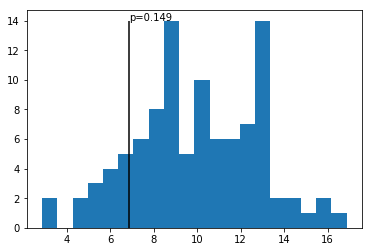

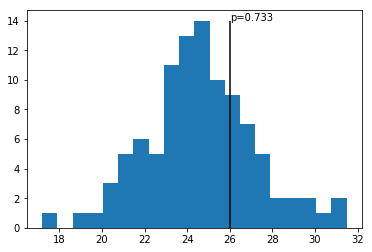

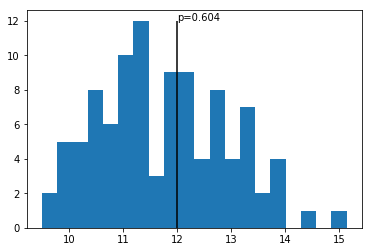

In [1116]:
PlotHistAndP(NVIQ_mean, 8.3)
PlotHistAndP(VABS_mean, 6.875)
PlotHistAndP(NVIQ_mean_, 26)
PlotHistAndP(VABS_mean_, 12)

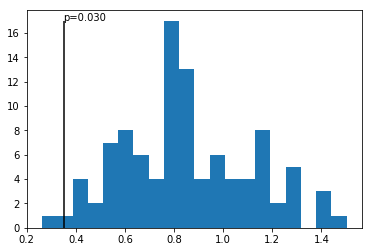

In [1118]:
PlotHistAndP(VIQRatios, 0.35)

In [1119]:
VIQRatios2, SelectedSamples_VIQ_NVIQ2 = RatioPermutationTest(ALL_NVIQ_VABS_Pairs, Npermute=100)

In [1120]:
NVIQ_mean, VABS_mean, NVIQ_mean_, VABS_mean_ = [], [], [], []
for sp in SelectedSamples_VIQ_NVIQ2:
    First8 = sp[:8]
    Last60 = sp[8:]
    NVIQ_mean.append(np.mean([x.NVIQ_DIFF for x in First8]))
    VABS_mean.append(np.mean([x.VABS_DIFF for x in First8]))
    NVIQ_mean_.append(np.mean([x.NVIQ_DIFF for x in Last60]))
    VABS_mean_.append(np.mean([x.VABS_DIFF for x in Last60]))

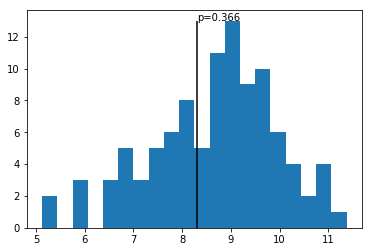

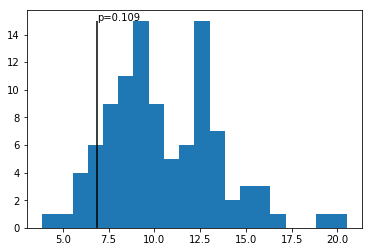

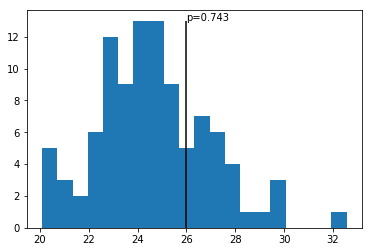

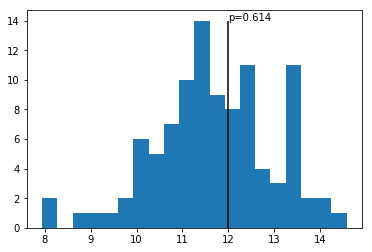

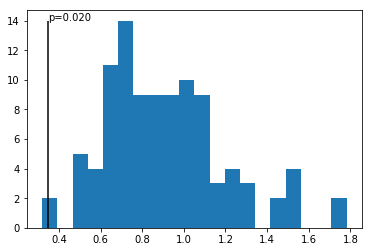

In [1122]:
PlotHistAndP(NVIQ_mean, 8.3)
PlotHistAndP(VABS_mean, 6.875)
PlotHistAndP(NVIQ_mean_, 26)
PlotHistAndP(VABS_mean_, 12)
PlotHistAndP(VIQRatios2, 0.35)

In [1139]:
VIQRatios3, SelectedSamples_VIQ_NVIQ3 = RatioPermutationTest(ALL_NVIQ_VABS_Pairs, N1 = 16, N2 = 8, Npermute=100)

In [1140]:
NVIQ_mean, VABS_mean, NVIQ_mean_, VABS_mean_ = [], [], [], []
for sp in SelectedSamples_VIQ_NVIQ3:
    First8 = sp[:8]
    Last60 = sp[8:]
    NVIQ_mean.append(np.mean([x.NVIQ_DIFF for x in First8]))
    VABS_mean.append(np.mean([x.VABS_DIFF for x in First8]))
    NVIQ_mean_.append(np.mean([x.NVIQ_DIFF for x in Last60]))
    VABS_mean_.append(np.mean([x.VABS_DIFF for x in Last60]))

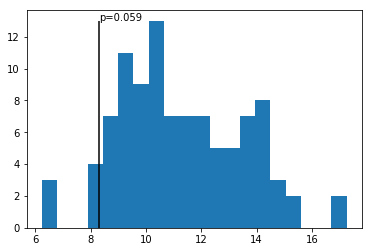

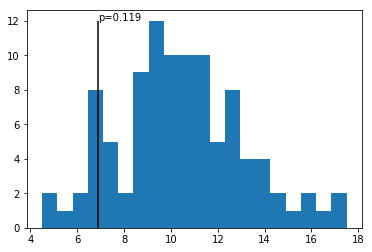

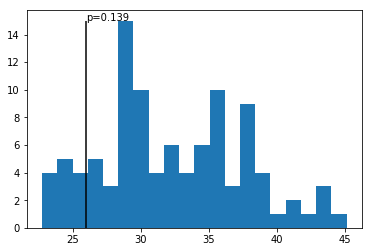

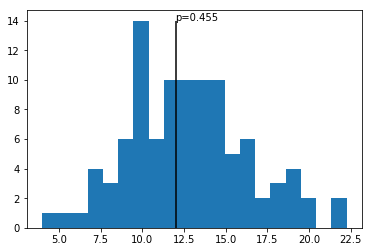

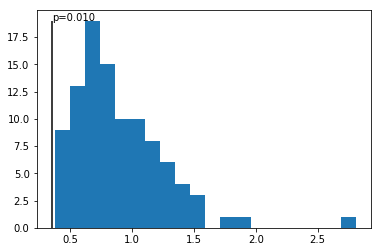

In [1141]:
PlotHistAndP(NVIQ_mean, 8.3)
PlotHistAndP(VABS_mean, 6.875)
PlotHistAndP(NVIQ_mean_, 26)
PlotHistAndP(VABS_mean_, 12)
PlotHistAndP(VIQRatios3, 0.35)

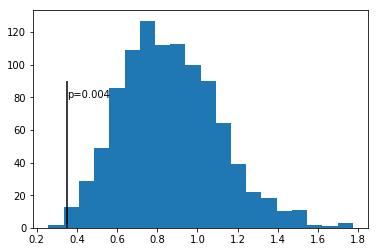

In [1093]:
plt.hist(res, bins=20)
p = get_smaller_P(0.35, [0] + res)
plt.vlines(x=0.35, ymin=0, ymax=90)
plt.text(x=0.35, y=80, s="p=%.3f"%p)
plt.show()

In [1136]:
ALL_NVIQ_VIQ_Pairs = [NVIQ_VABS_PAIR(x,y) for x,y in zip(ALL_NVIQ_diff, ALL_VIQ_diff)]
VIQRatios, SelectedSamples_VIQ_NVIQ = RatioPermutationTestNVIQvsVIQ(ALL_NVIQ_VIQ_Pairs, Npermute=100)

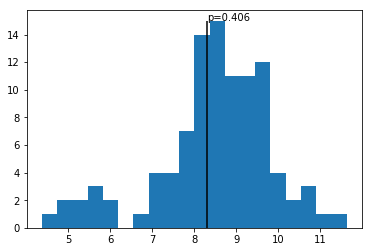

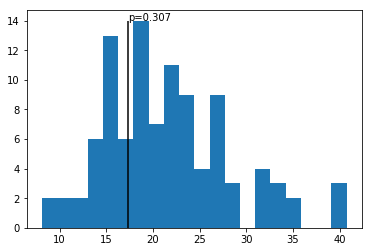

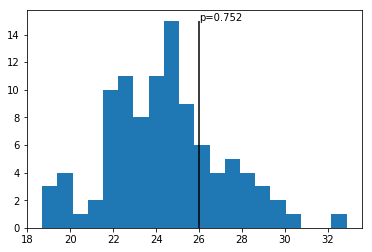

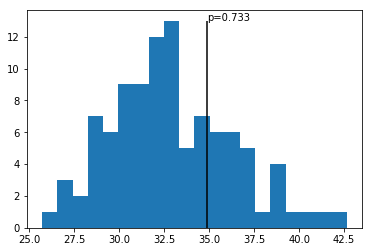

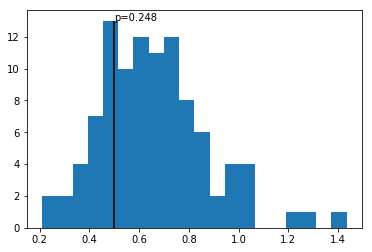

In [1138]:
NVIQ_mean, VABS_mean, NVIQ_mean_, VABS_mean_ = [], [], [], []
for sp in SelectedSamples_VIQ_NVIQ:
    First8 = sp[:8]
    Last60 = sp[8:]
    NVIQ_mean.append(np.mean([x.NVIQ_DIFF for x in First8]))
    VABS_mean.append(np.mean([x.VABS_DIFF for x in First8]))
    NVIQ_mean_.append(np.mean([x.NVIQ_DIFF for x in Last60]))
    VABS_mean_.append(np.mean([x.VABS_DIFF for x in Last60]))
PlotHistAndP(NVIQ_mean, 8.3)
PlotHistAndP(VABS_mean, 17.3)
PlotHistAndP(NVIQ_mean_, 26)
PlotHistAndP(VABS_mean_, 34.9)
PlotHistAndP(VIQRatios, 0.5)

In [1129]:
17.3/34.9

0.4957020057306591

900

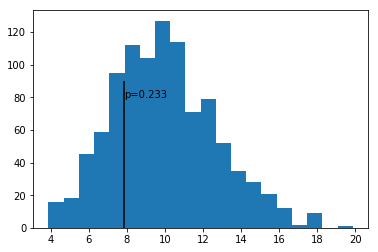

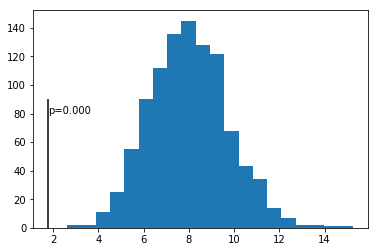

In [800]:
AVGIQs, AVG_dists = AccetRejectSamplingForPhenotypesRelationship(SE_NVIQ_diff, SE_VABS_diff, 
                                                                 ALL_NVIQ_diff, ALL_VABS_diff)
plt.hist(AVGIQs, bins=20)
p = get_smaller_P(np.mean(SameExonIQ), AVGIQs)
plt.vlines(x=np.mean(SameExonIQ), ymin=0, ymax=90)
plt.text(x=np.mean(SameExonIQ), y=80, s="p=%.3f"%p)
plt.show()


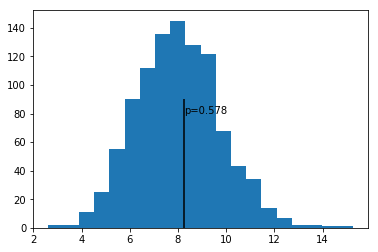

In [802]:

Log10SameExonAA = [x for x in SE_NVIQ_diff]
plt.hist(AVG_dists, bins=20)
p = get_smaller_P(np.mean(Log10SameExonAA), AVG_dists)
plt.vlines(x=np.mean(Log10SameExonAA), ymin=0, ymax=90)
plt.text(x=np.mean(Log10SameExonAA), y=80, s="p=%.3f"%p)
plt.show()

In [441]:
import itertools
sampled_FSIQ_diff = []
sampled_VIQ_diff = []
sampled_NVIQ_diff = []
sampled_VABS_diff = []
Mean_FSIQ_diff, Mean_VIQ_diff, Mean_NVIQ_diff, Mean_VABS_diff = [],[],[],[]
N,i = 0, 0
for row1, row2 in itertools.combinations(Jiayao_features.iterrows(), r=2):
    row1 = row1[1]
    row2 = row2[1]
    #NVIQ_diff = abs(row1["probandNVIQ"]- row2["probandNVIQ"])
    #VIQ_diff = abs(row1["probandVIQ"]- row2["probandVIQ"])
    FSIQ_diff = abs(row1["FSIQ"]- row2["FSIQ"])
    NVIQ_diff = abs(row1["NVIQ"]- row2["NVIQ"])
    VIQ_diff = abs(row1["VIQ"]- row2["VIQ"])
    VABS_diff = abs(row1["VABS"]- row2["VABS"])
    if FSIQ_diff <= 20 and FSIQ_diff >= 0:
        if i >= 8:
            #if np.mean(sampled_FSIQ_diff) > 5 and np.mean(sampled_FSIQ_diff) < 10:
            if np.mean(sampled_FSIQ_diff) > 8.8 and np.mean(sampled_FSIQ_diff) < 8.9:
                N += 1
                Mean_FSIQ_diff.append(np.mean(sampled_FSIQ_diff))
                Mean_VIQ_diff.append(np.mean(sampled_VIQ_diff))
                Mean_NVIQ_diff.append(np.mean(sampled_NVIQ_diff))
                Mean_VABS_diff.append(np.mean(sampled_VABS_diff))
            sampled_FSIQ_diff = []
            sampled_VIQ_diff = []
            sampled_NVIQ_diff = []
            sampled_VABS_diff = []
            i = 0
        sampled_FSIQ_diff.append(FSIQ_diff)
        sampled_NVIQ_diff.append(NVIQ_diff)
        sampled_VIQ_diff.append(VIQ_diff)
        sampled_VABS_diff.append(VABS_diff)
        i += 1
    if N > 1000:
        break
#print(np.mean(sampled_VIQ_diff), np.mean(sampled_NVIQ_diff))

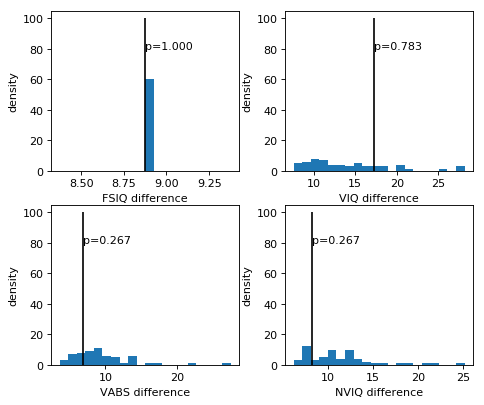

In [443]:
def get_smaller_P(xline, dist):
    count = 0
    for i,v in enumerate(dist):
        if xline >= v:
            count += 1
    return float(count)/len(dist)

fig, axs = plt.subplots(2,2,figsize=(6,5), dpi=80,)
axs = axs.flatten()
fig.tight_layout()
features = [('FSIQ', 8.875, Mean_FSIQ_diff), ('VIQ', 17.25, Mean_VIQ_diff), 
            ('VABS', 6.875, Mean_VABS_diff), ('NVIQ', 8.25, Mean_NVIQ_diff)]
for ax,feature in zip(axs, features):  
    label, xline, dist = feature
    p = get_smaller_P(xline, dist)
    ax.hist(dist, bins=20)
    ax.vlines(x=xline, ymin=0, ymax=100)
    ax.text(x=xline, y=80, s="p=%.3f"%p)
    ax.set_ylabel("density")
    ax.set_xlabel("%s difference"%(label))
#plt.show()

In [252]:
Jiayao_features = pd.read_csv("unifiedmodel/features.65.jiayao.csv")
#Jiayao_features.head(2)
tmpdf = Jiayao_features.drop_duplicates(subset="ExonID", keep='first')
print(tmpdf.shape)
r, p = pearsonr(np.array(tmpdf["phyloP100way"]), np.array(tmpdf["NVIQ"]))
print(r,p)
r, p = pearsonr(np.array(tmpdf["phastCons100way"]), np.array(tmpdf["NVIQ"]))
print(r,p)

(57, 30)
-0.2777379737839482 0.03645927041594309
-0.23583164454164451 0.07738797045741304


In [1143]:
# conservation scores
# Same gene highest phyloP score set similarity 
Jiayao_features = pd.read_csv("unifiedmodel/features.65.jiayao.csv")
Jiayao_features["VABS"] = Jiayao_features.apply(lambda row:indv2vabs.get(row["familyId"], np.nan), axis=1)
ExonCount = Jiayao_features.groupby("ExonID")["ExonID"].count()
Jiayao_features["ExonCount"] = Jiayao_features.apply(lambda row: ExonCount[row["ExonID"]], axis=1)
DiffExon = Jiayao_features[Jiayao_features["ExonCount"]<2]
DiffExonVIQ_diff, DiffExonNVIQ_diff, DiffExonVABS_diff = [], [], []
for gene in list(set(DiffExon['effectGene'].values)):
    #print(gene)
    tmpdf = DiffExon[DiffExon["effectGene"]==gene]
    tmpdf = tmpdf.sort_values('phyloP100way', ascending=False)
    if tmpdf.shape[0] < 2:
        continue
    #display(tmpdf)
    phyloPs = tmpdf["phyloP100way"].values
    phyloP_diff = phyloPs[0] - phyloPs[1]
    #print(phyloP_diff)
    if phyloP_diff > 1:
        continue
    VIQs = tmpdf["VIQ"].values
    NVIQs = tmpdf["NVIQ"].values
    VABSs = tmpdf["VABS"].values
    DiffExonVIQ_diff.append(abs(VIQs[0]-VIQs[1]))
    DiffExonNVIQ_diff.append(abs(NVIQs[0]-NVIQs[1]))
    DiffExonVABS_diff.append(abs(VABSs[0]-VABSs[1]))

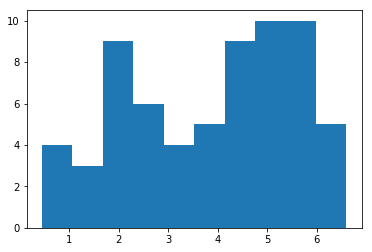

In [1144]:
plt.hist(Jiayao_features["phyloP100way"].values)
plt.show()

8 11


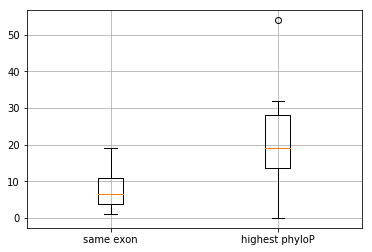

6.5 19.0
MannwhitneyuResult(statistic=19.5, pvalue=0.023657174348709568)


In [1145]:
print(len(SameExonNVIQ_diff), len(DiffExonNVIQ_diff))
plt.boxplot([SameExonNVIQ_diff, DiffExonNVIQ_diff],
            labels = ["same exon", "highest phyloP"])
plt.grid(True)
plt.show()
print(np.median(SameExonNVIQ_diff), np.median(DiffExonNVIQ_diff))
print(scipy.stats.mannwhitneyu(SameExonNVIQ_diff, DiffExonNVIQ_diff, alternative="less"))

In [1153]:
Jiayao_features = pd.read_csv("unifiedmodel/features.65.jiayao.csv")
Jiayao_features["VABS"] = Jiayao_features.apply(lambda row:indv2vabs.get(row["familyId"], np.nan), axis=1)
ExonCount = Jiayao_features.groupby("ExonID")["ExonID"].count()
Jiayao_features["ExonCount"] = Jiayao_features.apply(lambda row: ExonCount[row["ExonID"]], axis=1)
DiffExon = Jiayao_features[Jiayao_features["ExonCount"]<2]
DiffExonVIQ_diff, DiffExonNVIQ_diff, DiffExonVABS_diff = [], [], []
LargeConserveDiff, SmallConserveDiff = [],[]
IQDiffs, phyloPDiffs = [], []
for gene in list(set(DiffExon['effectGene'].values)):
    #print(gene)
    tmpdf = DiffExon[DiffExon["effectGene"]==gene]
    tmpdf = tmpdf.sort_values('phyloP100way', ascending=False)
    if tmpdf.shape[0] < 2:
        continue
    #display(tmpdf)
    for row1, row2 in itertools.combinations(tmpdf.iterrows(), 2):
        i1, row1 = row1
        i2, row2 = row2
        phyloP1 = row1["phyloP100way"]
        phyloP2 = row2["phyloP100way"]
        NVIQ1 = row1["NVIQ"]
        NVIQ2 = row2["NVIQ"]
        IQDiff = abs(NVIQ1-NVIQ2)
        phyloPDiff = abs(phyloP1 - phyloP2)
        IQDiffs.append(IQDiff)
        phyloPDiffs.append(phyloPDiff)
        if phyloPDiff > 1:
            LargeConserveDiff.append(IQDiff)
        elif phyloPDiff < 1:
            SmallConserveDiff.append(IQDiff)

(-0.07907480513850859, 0.6566578624481061)
SpearmanrResult(correlation=-0.03179213071232551, pvalue=0.8583386783449299)


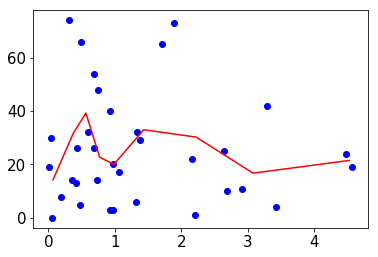

Text(0, 0.5, 'NVIQ difference')

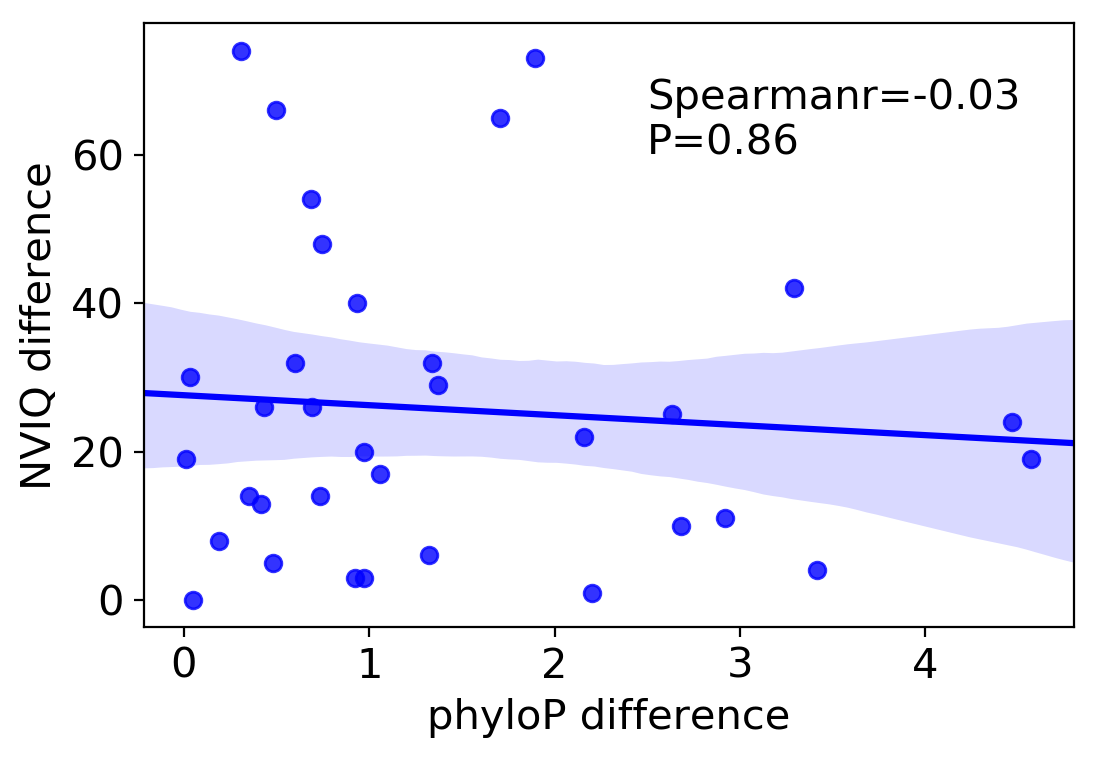

In [1189]:
plt.scatter(phyloPDiffs, IQDiffs, color="blue")
Xs, Ys = MyMovingAVG(phyloPDiffs, IQDiffs, 4)
plt.plot(Xs, Ys, color="red")
print(pearsonr(phyloPDiffs, IQDiffs))
print(spearmanr(phyloPDiffs, IQDiffs))
plt.show()

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}
mpl.rc('font', **font)
fig, ax = plt.subplots(dpi=200)
ax = sns.regplot(x=phyloPDiffs, y=IQDiffs, color="blue", ci=95)
r, p = spearmanr(phyloPDiffs, IQDiffs)
ax.text(x = 2.5, y=60, s="Spearmanr=%.2f\nP=%.2f"%(r,p))
ax.set_xlabel("phyloP difference")
ax.set_ylabel("NVIQ difference")

8 15 19


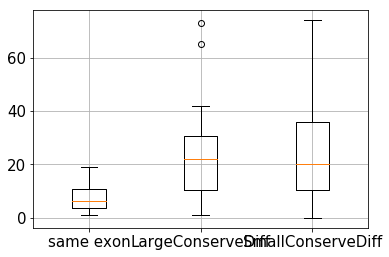

22.0 20.0
MannwhitneyuResult(statistic=140.0, pvalue=0.4723374811509226)


In [1185]:
print(len(SameExonNVIQ_diff), len(LargeConserveDiff), len(SmallConserveDiff))
plt.boxplot([SameExonNVIQ_diff, LargeConserveDiff, SmallConserveDiff],
            labels = ["same exon", "LargeConserveDiff", "SmallConserveDiff"])
plt.grid(True)
plt.show()
print(np.median(LargeConserveDiff), np.median(SmallConserveDiff))
print(scipy.stats.mannwhitneyu(LargeConserveDiff, SmallConserveDiff, alternative="less"))

In [816]:
RecGenes = ["ASXL3","CHD2","CHD8","DSCAM","DYRK1A","FOXP1","HIVEP2","SCN2A","ADNP","CHAMP1","CSNK2A1","GRIN2B",
        "HNRNPH2","MED13L","PACS1","PPP2R5D","SETBP1","STXBP1","SYNGAP1"]
Jiayao_features = pd.read_csv("unifiedmodel/features.jiayao.65.csv")
#df = Jiayao_features[Jiayao_features["effectGene"].isin(Genes)]
df = Jiayao_features
#display(df.head(2))
for i, row in df.iterrows():
    df.loc[i, "sfari_id"] = df.loc[i, "familyId"]
    df.loc[i, "sex"] = df.loc[i, "gender"]
    Chr, Pos, Ref, Alt = row["vcfVariant"].split(":")
    Len = max(0, len(Ref) - len(Alt))
    df.loc[i, "location"] = "{}:{}-{}".format(Chr, Pos, int(Pos)+Len)
    df.loc[i, "inheritance_status"] = "de-novo"
    df.loc[i, "genetic_status"] = row["effectGene"]
    df.loc[i, "composite_standard_score"] = row["VABS"]
    df.loc[i, "Cohort"] = "SSC"
#df.head(2)
df = df[["Cohort", "sfari_id","sex","genetic_status","inheritance_status","composite_standard_score","location"]]

In [817]:
df.head(2)

,Cohort,sfari_id,sex,genetic_status,inheritance_status,composite_standard_score,location
0,SSC,13545.0,M,ADNP,de-novo,53.0,20:49509094-49509094
1,SSC,12130.0,F,ADNP,de-novo,67.0,20:49510027-49510029


In [818]:
VIP_VABS = pd.read_csv("unifiedmodel/vip.recgenes.withlocation.csv")
VIP_VABS.head(2)

,sfari_id,sex,genetic_status,inheritance_status,composite_standard_score,location
0,15710-x1,M,ASXL3,de-novo,75.0,18:31323776-31323776
1,16159-x1,F,ASXL3,de-novo,37.0,18:31319345-31319349


In [819]:
sfari_id2vabs = {}
for sfari_id in VIP_VABS["sfari_id"].values:
    #print(sfari_id)
    tmpdf = VIP_VABS[VIP_VABS["sfari_id"]==sfari_id]
    vabs = np.mean(tmpdf["composite_standard_score"].values)
    sfari_id2vabs[sfari_id] = vabs

In [820]:
print(VIP_VABS.shape)
VIP_VABS = VIP_VABS.drop_duplicates(subset="sfari_id", keep="first")
#VIP_VABS.head(2)
print(VIP_VABS.shape)
VIP_VABS["composite_standard_score"] = VIP_VABS.apply(lambda row:sfari_id2vabs[row["sfari_id"]], axis=1)
VIP_VABS["Cohort"] = "VIP"

(123, 6)
(89, 6)


In [821]:
VABS = pd.concat([df, VIP_VABS])
VABS = VABS[VABS["inheritance_status"]=="de-novo"]
#VABS = VABS.dropna()
VABS = VABS.reset_index(drop=True)

/Users/jiayao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [822]:
VABS.to_csv("unifiedmodel/SSC_VIP_VABS_RecLGD.csv", index=False)

In [823]:
Gene2Trans = {}
"""
hand = open("unifiedmodel/VIPgenes.gencode.v19.gtf", 'rt')
for l in hand:
    if l.startswith("#"):
        continue
    llist = l.strip().split("\t")
    info = gtf_info_parser(llist[8]) 
    CHR = llist[0].lstrip("chr")
    strand = llist[6]
    start = int(llist[3])
    end = int(llist[4])
    if llist[2] == "transcript" and info["transcript_type"] == "protein_coding":
        if info["gene_name"] not in Gene2Trans:
            Gene2Trans[info["gene_name"]] = (info["transcript_id"], abs(start - end))
        else:
            if abs(start-end) > Gene2Trans[info["gene_name"]][1]:
                Gene2Trans[info["gene_name"]] = (info["transcript_id"], abs(start - end))
"""
Gene2Trans["ASXL3"]="ENST00000269197.5"
Gene2Trans["CHD8"]="ENST00000399982.2"
Gene2Trans["DYRK1A"]="ENST00000339659.4"
Gene2Trans["CHD2"]="ENST00000394196.4"
Gene2Trans["SCN2A"]="ENST00000357398.3"
Gene2Trans["FOXP1"]="ENST00000318789.4"
Gene2Trans["HIVEP2"]="ENST00000367603.2"
Gene2Trans["PPP2R5D"]="ENST00000485511.1"
Gene2Trans["HIVEP2"]="ENST00000367603.2"
Gene2Trans["SYNGAP1"]="ENST00000418600.2"
Gene2Trans["STXBP1"]="ENST00000373302.3"
Gene2Trans["PACS1"]="ENST00000320580.4"
Gene2Trans["MED13L"]="ENST00000281928.3"
Gene2Trans["CHAMP1"]="ENST00000361283.1"
Gene2Trans["SETBP1"]="ENST00000282030.5"
Gene2Trans["CSNK2A1"]="ENST00000217244.3"
Gene2Trans["ADNP"]="ENST00000396029.3"
Gene2Trans["DSCAM"]="ENST00000400454.1"
Gene2Trans["HNRNPH2"]="ENST00000400454.1"
Gene2Trans["GRIN2B"]="ENST00000609686.1"
print (Gene2Trans)
selectedTrans = []
for k,v in Gene2Trans.items():
    selectedTrans.append(v)
print(selectedTrans)

{'ASXL3': 'ENST00000269197.5', 'CHD8': 'ENST00000399982.2', 'DYRK1A': 'ENST00000339659.4', 'CHD2': 'ENST00000394196.4', 'SCN2A': 'ENST00000357398.3', 'FOXP1': 'ENST00000318789.4', 'HIVEP2': 'ENST00000367603.2', 'PPP2R5D': 'ENST00000485511.1', 'SYNGAP1': 'ENST00000418600.2', 'STXBP1': 'ENST00000373302.3', 'PACS1': 'ENST00000320580.4', 'MED13L': 'ENST00000281928.3', 'CHAMP1': 'ENST00000361283.1', 'SETBP1': 'ENST00000282030.5', 'CSNK2A1': 'ENST00000217244.3', 'ADNP': 'ENST00000396029.3', 'DSCAM': 'ENST00000400454.1', 'HNRNPH2': 'ENST00000400454.1', 'GRIN2B': 'ENST00000609686.1'}
['ENST00000269197.5', 'ENST00000399982.2', 'ENST00000339659.4', 'ENST00000394196.4', 'ENST00000357398.3', 'ENST00000318789.4', 'ENST00000367603.2', 'ENST00000485511.1', 'ENST00000418600.2', 'ENST00000373302.3', 'ENST00000320580.4', 'ENST00000281928.3', 'ENST00000361283.1', 'ENST00000282030.5', 'ENST00000217244.3', 'ENST00000396029.3', 'ENST00000400454.1', 'ENST00000400454.1', 'ENST00000609686.1']


In [824]:
Genes = {}
hand = open("unifiedmodel/VIPgenes.gencode.v19.gtf", 'rt')
for l in hand:
    if l.startswith("#"):
        continue
    llist = l.strip().split("\t")
    info = gtf_info_parser(llist[8]) 
    CHR = llist[0].lstrip("chr")
    strand = llist[6]
    start = int(llist[3])
    end = int(llist[4])
    if llist[2] == "gene":
        gene_name = info["gene_name"]
        gene_id = info["gene_id"]
        Genes[gene_name] = GTFGene(gene_name, gene_id, strand)
    elif llist[2] == "transcript":
        gene_name = info["gene_name"]
        gene_id = info["gene_id"]
        transcript_name = info["transcript_id"]
        transcript_id = info["transcript_id"]
        transcript_type = info["transcript_type"]
        if transcript_id not in Genes[gene_name].Transcripts and transcript_type=="protein_coding" and transcript_id in selectedTrans:
            Genes[gene_name].Transcripts[transcript_id] = GTFTranscript(gene_name, transcript_name, transcript_id, strand)
    elif llist[2] == "exon":
        gene_name = info["gene_name"]
        gene_id = info["gene_id"]
        exon_id = info["exon_id"]
        transcript_name = info["transcript_id"]
        transcript_id = info["transcript_id"]
        transcript_type = info["transcript_type"]
        if transcript_type=="protein_coding" and transcript_id in selectedTrans:
            exon= GTFExon(exon_id, start, end, transcript_id, strand)
            #Genes[gene_name].Transcripts[transcript_id].Exons.append(exon)
            Genes[gene_name].Transcripts[transcript_id].Exons[exon_id] = exon
            

In [825]:
exon_exp_col = pd.read_csv(
    "/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/exons_matrix/columns_metadata.csv")
exon_exp_row = pd.read_csv(
    "/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/exons_matrix/rows_metadata.csv")
cds_dict = loaddict()
display(exon_exp_col.head(2))
display(exon_exp_row.head(2))

,column_num,donor_id,donor_name,age,gender,structure_id,structure_acronym,structure_name
0,1,13058,H376.IIA.51,8 pcw,M,10665,URL,upper (rostral) rhombic lip
1,2,13058,H376.IIA.51,8 pcw,M,10194,OFC,orbital frontal cortex


,row_num,gene_id,ensembl_gene_id,gene_symbol,entrez_id,start,end
0,1,1086864,ENSG00000000003,TSPAN6,7105.0,99883666,99884983
1,2,1086864,ENSG00000000003,TSPAN6,7105.0,99885755,99885863


In [826]:
def searchExon(Gene, Location, Genes):
    Chr, interval = Location.split(":")
    Start, End = interval.split("-")
    Pos, LenV = int(Start), int(End)-int(Start)
    gene_obj = Genes[Gene]
    _Exons, Transcripts = [],[]
    #print(Location, Pos, LenV)
    islej = "F"
    for transid, transobj in gene_obj.Transcripts.items():
        if transid not in selectedTrans:
            continue
        transobj.SortExons()
        for exon in transobj.ExonSeq:
            if Pos > exon.start -3 and Pos < exon.end +3:
                _Exons.append(exon.ExonID)
                Transcripts.append(transid)
                break
            elif LenV > 0:
                if (Pos < exon.start-3 and Pos + LenV > exon.start ) or (Pos < exon.end and Pos + LenV > exon.end +3):
                    _Exons.append(exon.ExonID)
                    Transcripts.append(transid)
                    break
    for transid, transobj in gene_obj.Transcripts.items():
        if len(transobj.Exons) >= 2:
            interval1, interval2 = transobj.LastExonJunction()
            if Gene=="CHD2":
                print(interval1, interval2)
            if (Pos > interval1[0] and Pos < interval1[1]):
                islej = "T"
            elif (Pos > interval2[0] and Pos < interval2[1]):
                islej = "T"
    if len(list(set(_Exons))) == 0:
        return "NA", "NA", "NA"
    else:
        return list(set(_Exons))[0], list(set(Transcripts))[0], islej


VABS["Exons"] = ""
VABS["Transcripts"] = ""
VABS = VABS[VABS["Cohort"]=="VIP"]
for i, row in VABS.iterrows():
    famid, gene, location = row["sfari_id"], row["genetic_status"], row["location"]
    ExonIDs, TranscriptIDs, islej = searchExon(gene, location, Genes)
    VABS.at[i, "Exons"] = ExonIDs
    VABS.at[i, "Transcripts"] = TranscriptIDs
    VABS.at[i, "isLEJ"] = islej

In [827]:
VABS2 = VABS[VABS["isLEJ"]=="T"]
VABS.head(2)
#VABS2

,Cohort,composite_standard_score,genetic_status,inheritance_status,location,sex,sfari_id,Exons,Transcripts,isLEJ
65,VIP,75.0,ASXL3,de-novo,18:31323776-31323776,M,15710-x1,ENSE00000948514.2,ENST00000269197.5,T
66,VIP,37.0,ASXL3,de-novo,18:31319345-31319349,F,16159-x1,ENSE00003631966.1,ENST00000269197.5,F


In [868]:
ASXL3 = DF[DF["genetic_status"]=="ASXL3"]
print(ASXL3[ASXL3["Exons"]=="ENSE00000948514"].shape)
print(ASXL3[ASXL3["Exons"]=="ENSE00003631966"].shape)

(11, 16)
(7, 16)


In [869]:
7*11

77

In [985]:
res = {}
VABS2 = VABS[~VABS["sfari_id"].isin(["16159-x1", "16171-x1"])]
for gene in RecGenes:
    res[gene] = {}
    res[gene]["SameExon"] = []
    res[gene]["SameExonSameGender"] = []
    res[gene]["DiffExon"] = []
    #df = VABS2[VABS2["genetic_status"]==gene]
    df = DFF[DFF["genetic_status"]==gene]
    
    for row1, row2 in itertools.combinations(df.iterrows(), r=2):
        row1,row2 = row1[1], row2[1]
        score1 = row1["composite_standard_score"]
        score2 = row2["composite_standard_score"]
        if row1["Exons"] == row2["Exons"]:
            if row1["isLEJ"] == "T" or row2["isLEJ"] == "T":
                continue
            res[gene]["SameExon"].append( abs(score1-score2) )
            if row1["sex"] == row2["sex"]:
                res[gene]["SameExonSameGender"].append( abs(score1-score2) )
        else:
            res[gene]["DiffExon"].append( abs(score1-score2) )

In [989]:
SameExonMeans, DiffExonMeans, SameExonSameGenderMeans, DiffExonMeans2 = [],[],[],[]
print("%20s\t%20s\t%s\t%s\t%s\t%s\t"%("SameExonVABSDiff", "NSameExonPair","SameExonSameGenderVABSDiff",
                                            "NSameExonSameGenderPair","SameGeneVABSDiff", "NSameGenePair"))
ExcludedGene = []
for gene in RecGenes:
    #if gene=="FOXP1":
    #    continue
    SameExon = res[gene]["SameExon"]
    SameExonSameGender = res[gene]["SameExonSameGender"]
    DiffExon = res[gene]["DiffExon"]
    if len(SameExon) == 0 or len(DiffExon) == 0:
        ExcludedGene.append(gene)
        continue
    SameExonMeans.append(np.mean(SameExon))
    DiffExonMeans.append(np.mean(DiffExon))
    if len(SameExonSameGender) != 0:
        SameExonSameGenderMeans.append(np.mean(SameExonSameGender))
        DiffExonMeans2.append(np.mean(DiffExon))
    print("%s\t%.2f\t%d\t%.2f\t%d\t%.2f\t%d"%(gene, np.mean(SameExon), len(SameExon), np.mean(SameExonSameGender), 
                                    len(SameExonSameGender), np.mean(DiffExon), len(DiffExon)))
print(SameExonMeans, DiffExonMeans)
print(scipy.stats.wilcoxon(SameExonMeans, DiffExonMeans))
print(scipy.stats.wilcoxon(SameExonSameGenderMeans, DiffExonMeans2))
print(ExcludedGene)

    SameExonVABSDiff	       NSameExonPair	SameExonSameGenderVABSDiff	NSameExonSameGenderPair	SameGeneVABSDiff	NSameGenePair	
CHD2	2.00	1	2.00	1	18.00	2
CHD8	11.00	1	nan	0	12.75	20
DYRK1A	12.33	6	13.33	3	17.23	22
HIVEP2	5.67	3	8.50	1	13.17	3
SCN2A	10.95	7	6.75	4	13.81	113
[2.0, 11.0, 12.333333333333334, 5.666666666666667, 10.95238095238095] [18.0, 12.75, 17.227272727272727, 13.166666666666666, 13.811209439528024]
WilcoxonResult(statistic=0.0, pvalue=0.043114446783075355)
WilcoxonResult(statistic=0.0, pvalue=0.06788915486182899)
['ASXL3', 'DSCAM', 'FOXP1', 'ADNP', 'CHAMP1', 'CSNK2A1', 'GRIN2B', 'HNRNPH2', 'MED13L', 'PACS1', 'PPP2R5D', 'SETBP1', 'STXBP1', 'SYNGAP1']


/Users/jiayao/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/jiayao/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jiayao/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/Users/jiayao/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


In [987]:
print(scipy.stats.mannwhitneyu(res["SCN2A"]["SameExon"], res["SCN2A"]["DiffExon"]))
print(scipy.stats.mannwhitneyu(res["ASXL3"]["SameExon"], res["ASXL3"]["DiffExon"]))
print(scipy.stats.mannwhitneyu(res["DYRK1A"]["SameExon"], res["DYRK1A"]["DiffExon"]))
print(scipy.stats.mannwhitneyu(res["HIVEP2"]["SameExon"], res["HIVEP2"]["DiffExon"]))

MannwhitneyuResult(statistic=320.5, pvalue=0.20198804819876492)
MannwhitneyuResult(statistic=0.0, pvalue=0.0)
MannwhitneyuResult(statistic=53.0, pvalue=0.24077074348902505)
MannwhitneyuResult(statistic=0.0, pvalue=0.04042779918502612)


/Users/jiayao/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4911: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


In [600]:
VABS[VABS["genetic_status"]=="CHD2"]

,sfari_id,sex,genetic_status,inheritance_status,composite_standard_score,location,Exons,Transcripts,isLEJ
2,13618,F,CHD2,de-novo,57.0,15:93524060-93524064,ENSE00001097780.1,ENST00000394196.4,F
3,13614,M,CHD2,de-novo,74.0,15:93563244-93563244,ENSE00001517730.1,ENST00000394196.4,T
4,13818,M,CHD2,de-novo,76.0,15:93563282-93563282,ENSE00001517730.1,ENST00000394196.4,T


In [673]:
SameExon = []
SameExonSameGender = []
SameGene = []
ALLPairs = []
Test = VABS[VABS["genetic_status"]!="ASXL3"]
for row1, row2 in itertools.combinations(Test.iterrows(), r=2):
    row1,row2 = row1[1], row2[1]
    score1 = row1["composite_standard_score"]
    score2 = row2["composite_standard_score"]
    diff = abs(score1-score2)
    ALLPairs.append(diff)
    if row1["genetic_status"] == row2["genetic_status"]:
        SameGene.append(diff)
        if row1["Exons"] == row2["Exons"]:
            if row1["isLEJ"] == "T" or row2["isLEJ"] == "T":
                continue
            SameExon.append(diff)
            if row1["sex"] == row2["sex"]:
                SameExonSameGender.append(diff)

In [674]:
Seq = [SameExonSameGender, SameExon, SameGene, ALLPairs]
Dat = [np.mean(x) for x in Seq]
Err = [np.std(x)/math.sqrt(len(x)) for x in Seq]

MannwhitneyuResult(statistic=769.5, pvalue=0.02705719185440645)

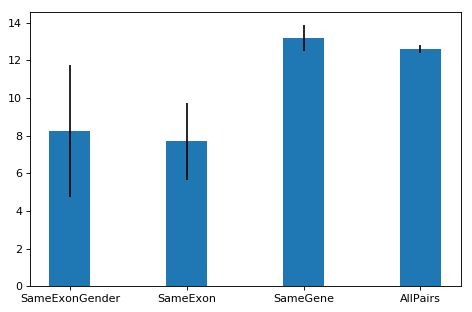

In [676]:
scipy.stats.mannwhitneyu(SameExon, SameGene)
ind = np.arange(4)  # the x locations for the groups
width = 0.35  # the width of the bars
fig, ax = plt.subplots(dpi=80)
rects = ax.bar(ind, Dat, width, yerr=Err,)
ax.set_ylabel('')
ax.set_title('')
ax.set_xticks(ind)
ax.set_xticklabels(["SameExonGender", "SameExon", "SameGene", "AllPairs"])
fig.tight_layout()
plt.xticks(rotation=0)
plt.show()

In [849]:
# Combine The two
GTFTree4SSC = LoadGTF("unifiedmodel/RecLGDgenes.gencode.v19.gtf")
GTFTree4VIP = LoadGTF("unifiedmodel/VIPgenes.gencode.v19.gtf")
GTFTree = {}
for gene, geneobj in GTFTree4SSC.items():
    GTFTree[gene] = geneobj
for gene, geneobj in GTFTree4VIP.items():
    if gene not in GTFTree:
        GTFTree[gene] = geneobj

In [850]:
# Annotate each variant with a transcript
DF = pd.read_csv("unifiedmodel/SSC_VIP_VABS_RecLGD.csv")
DF.loc[DF["genetic_status"]=="MLL5", "genetic_status"] = "KMT2E" 
xxx = pd.read_csv("unifiedmodel/peptide-position-jy.csv")
xxx.loc[xxx["effectGene"]=="MLL5", "effectGene"] = "KMT2E" 
Gene2Trans2 = dict(zip(xxx["effectGene"].values, xxx["Transcript"].values))
display(DF.head(2))
Gene2Trans
Gene2Trans2
for i, row in DF.iterrows():
    if row["genetic_status"] in Gene2Trans:
        transcript = Gene2Trans[row["genetic_status"]]
    else:
        transcript = Gene2Trans2[row["genetic_status"]]
    DF.loc[i, "Transcript"] = transcript.split(".")[0]

,Cohort,composite_standard_score,genetic_status,inheritance_status,location,sex,sfari_id
0,SSC,53.0,ADNP,de-novo,20:49509094-49509094,M,13545.0
1,SSC,67.0,ADNP,de-novo,20:49510027-49510029,F,12130.0


In [851]:
for i, row in DF.iterrows():
    #Chr, Pos, Ref, Alt = row["vcfVariant"].split(":")
    Chr, Pos = row["location"].split(":")
    Pos = int(Pos.split("-")[0])
    gene = row["genetic_status"]
    geneobj = GTFTree[gene]
    transobj = geneobj.Transcripts[row["Transcript"]]
    transobj.SortExons()
    varPos, TotalLength = searchAAPos(Pos, transobj)
    if varPos != "NA":
        DF.loc[i, "ProteinPos"] = str(int(varPos/3))
    else:
        DF.loc[i, "ProteinPos"] = str("NA")

In [852]:
DF = DF[DF["ProteinPos"]!="NA"]
GeneCount = DF.groupby("genetic_status")["genetic_status"].count()
DF["GeneCount"] = DF.apply(lambda row: GeneCount[row["genetic_status"]], axis=1)
DF = DF[DF["GeneCount"]>=2]

In [853]:
def searchExon(Gene, Location, GTFTree, Transcript):
    Chr, interval = Location.split(":")
    Start, End = interval.split("-")
    Pos, LenV = int(Start), int(End)-int(Start)
    gene_obj = GTFTree[Gene]
    _Exons = []
    #print(Location, Pos, LenV)
    islej = "F"
    transobj = gene_obj.Transcripts[Transcript]
    transobj.SortExons()
    for exon in transobj.ExonSeq:
        if Pos > exon.start -3 and Pos < exon.end +3:
            _Exons.append(exon.ExonID)
            break
        elif LenV > 0:
            if (Pos < exon.start-3 and Pos + LenV > exon.start ) or (Pos < exon.end and Pos + LenV > exon.end +3):
                _Exons.append(exon.ExonID)
                break
    if len(transobj.Exons) >= 2:
        interval1, interval2 = transobj.LastExonJunction()
        if (Pos > interval1[0] and Pos < interval1[1]):
            islej = "T"
        elif (Pos > interval2[0] and Pos < interval2[1]):
            islej = "T"
    if len(list(set(_Exons))) == 0:
        return "NA", "NA"
    else:
        return list(set(_Exons))[0], islej


DF["Exons"] = ""
for i, row in DF.iterrows():
    famid, gene, location = row["sfari_id"], row["genetic_status"], row["location"]
    ExonIDs, islej = searchExon(gene, location, GTFTree, row["Transcript"])
    DF.at[i, "Exons"] = ExonIDs
    DF.at[i, "isLEJ"] = islej

In [854]:
ExonCount = DF.groupby("Exons")["Exons"].count()
DF["ExonCount"] = DF.apply(lambda row: ExonCount[row["Exons"]], axis=1)
SameExon = DF[DF["ExonCount"]>=2]

In [855]:
DF["effectGene"] = DF["genetic_status"]
DF["ExonID"] = DF["Exons"]
DF["vcfVariant"] = DF["location"]

In [856]:
DFF = DF[DF["isLEJ"]=="F"]
Test = DFF[~DFF["sfari_id"].isin(["16159-x1", "16171-x1"])]

In [857]:
DFF[DFF["effectGene"]=="ASXL3"]

,Cohort,composite_standard_score,genetic_status,inheritance_status,location,sex,sfari_id,Transcript,ProteinPos,GeneCount,Exons,isLEJ,ExonCount,effectGene,ExonID,vcfVariant
66,VIP,37.00,ASXL3,de-novo,18:31319345-31319349,F,16159-x1,ENST00000269197,655,18,ENSE00003631966,F,7,ASXL3,ENSE00003631966,18:31319345-31319349
67,VIP,32.00,ASXL3,de-novo,18:31318721-31318722,F,16171-x1,ENST00000269197,447,18,ENSE00003631966,F,7,ASXL3,ENSE00003631966,18:31318721-31318722
68,VIP,57.00,ASXL3,de-novo,18:31318559-31318563,F,16179-x1,ENST00000269197,393,18,ENSE00003631966,F,7,ASXL3,ENSE00003631966,18:31318559-31318563
70,VIP,49.00,ASXL3,de-novo,18:31318839-31318839,M,16188-x1,ENST00000269197,486,18,ENSE00003631966,F,7,ASXL3,ENSE00003631966,18:31318839-31318839
75,VIP,59.25,ASXL3,de-novo,18:31319345-31319349,F,15215-x1,ENST00000269197,655,18,ENSE00003631966,F,7,ASXL3,ENSE00003631966,18:31319345-31319349
76,VIP,55.00,ASXL3,de-novo,18:31318846-31318848,F,15234-x1,ENST00000269197,489,18,ENSE00003631966,F,7,ASXL3,ENSE00003631966,18:31318846-31318848
77,VIP,64.00,ASXL3,de-novo,18:31319307-31319307,F,15452-x1,ENST00000269197,642,18,ENSE00003631966,F,7,ASXL3,ENSE00003631966,18:31319307-31319307


In [792]:
SameExonAA, SameExonIQ, DiffExonAA, DiffExonIQ = GetPairsForAAdistPhenotype(Test, "composite_standard_score")

HIVEP2 ENST00000367603 6:143093049-143093049 6:143093049-143093049
SCN2A ENST00000357398 2:166165305-166165305 2:166165305-166165305


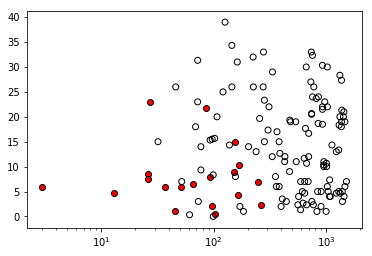

In [793]:
fig = plt.figure()
ax = fig.subplots(1,1)
ax.scatter(SameExonAA, SameExonIQ, color="red", facecolors='red', edgecolors='black')
ax.scatter(DiffExonAA, DiffExonIQ, color="black", facecolors='none', edgecolors='black')
ax.set_xscale('log')
plt.show()

In [794]:
AVGIQs, AVG_dists = AccetRejectSamplingForSameDiffExonAAdist(SameExonAA, SameExonIQ, DiffExonAA, DiffExonIQ)

900

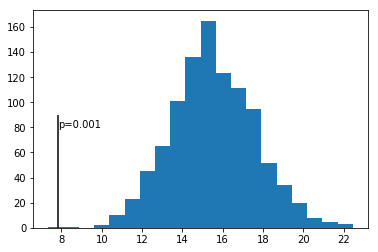

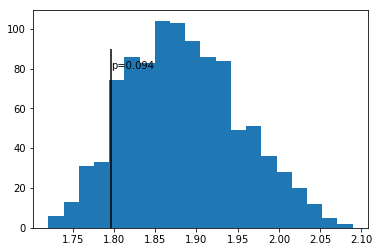

In [795]:
plt.hist(AVGIQs, bins=20)
p = get_smaller_P(np.mean(SameExonIQ), AVGIQs)
plt.vlines(x=np.mean(SameExonIQ), ymin=0, ymax=90)
plt.text(x=np.mean(SameExonIQ), y=80, s="p=%.3f"%p)
plt.show()

Log10SameExonAA = [math.log10(x) for x in SameExonAA]
plt.hist(AVG_dists, bins=20)
p = get_smaller_P(np.mean(Log10SameExonAA), AVG_dists)
plt.vlines(x=np.mean(Log10SameExonAA), ymin=0, ymax=90)
plt.text(x=np.mean(Log10SameExonAA), y=80, s="p=%.3f"%p)
plt.show()

In [729]:
DF2 = DFF[DFF["genetic_status"]!="ASXL3"]
SameExonAA, SameExonIQ, DiffExonAA, DiffExonIQ = GetPairsForAAdistPhenotype(DF2, "composite_standard_score")

HIVEP2 ENST00000367603 6:143093049-143093049 6:143093049-143093049
SCN2A ENST00000357398 2:166201379-166201379 2:166201379-166201379
SCN2A ENST00000357398 2:166165305-166165305 2:166165305-166165305


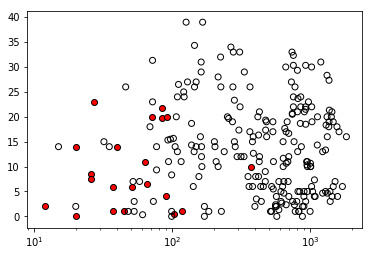

In [730]:
fig = plt.figure()
ax = fig.subplots(1,1)
ax.scatter(SameExonAA, SameExonIQ, color="red", facecolors='red', edgecolors='black')
ax.scatter(DiffExonAA, DiffExonIQ, color="black", facecolors='none', edgecolors='black')
ax.set_xscale('log')
plt.show()

In [731]:
AVGIQs, AVG_dists = AccetRejectSamplingForSameDiffExonAAdist(SameExonAA, SameExonIQ, DiffExonAA, DiffExonIQ)

900

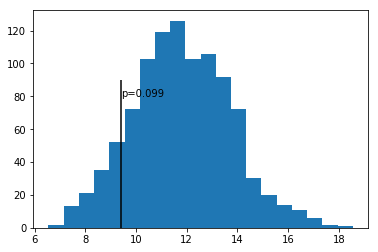

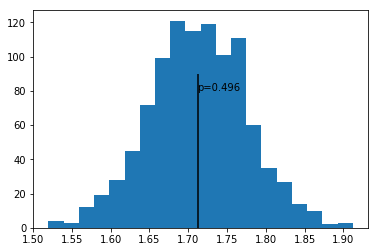

In [732]:
plt.hist(AVGIQs, bins=20)
p = get_smaller_P(np.mean(SameExonIQ), AVGIQs)
plt.vlines(x=np.mean(SameExonIQ), ymin=0, ymax=90)
plt.text(x=np.mean(SameExonIQ), y=80, s="p=%.3f"%p)
plt.show()

Log10SameExonAA = [math.log10(x) for x in SameExonAA]
plt.hist(AVG_dists, bins=20)
p = get_smaller_P(np.mean(Log10SameExonAA), AVG_dists)
plt.vlines(x=np.mean(Log10SameExonAA), ymin=0, ymax=90)
plt.text(x=np.mean(Log10SameExonAA), y=80, s="p=%.3f"%p)
plt.show()

In [761]:
DF[(DF["genetic_status"]=="ASXL3")&(DF["isLEJ"]=="F")]

,Cohort,composite_standard_score,genetic_status,inheritance_status,location,sex,sfari_id,Transcript,ProteinPos,GeneCount,Exons,isLEJ,ExonCount,effectGene,ExonID,vcfVariant
66,VIP,37.00,ASXL3,de-novo,18:31319345-31319349,F,16159-x1,ENST00000269197,655,18,ENSE00003631966,F,7,ASXL3,ENSE00003631966,18:31319345-31319349
67,VIP,32.00,ASXL3,de-novo,18:31318721-31318722,F,16171-x1,ENST00000269197,447,18,ENSE00003631966,F,7,ASXL3,ENSE00003631966,18:31318721-31318722
68,VIP,57.00,ASXL3,de-novo,18:31318559-31318563,F,16179-x1,ENST00000269197,393,18,ENSE00003631966,F,7,ASXL3,ENSE00003631966,18:31318559-31318563
70,VIP,49.00,ASXL3,de-novo,18:31318839-31318839,M,16188-x1,ENST00000269197,486,18,ENSE00003631966,F,7,ASXL3,ENSE00003631966,18:31318839-31318839
75,VIP,59.25,ASXL3,de-novo,18:31319345-31319349,F,15215-x1,ENST00000269197,655,18,ENSE00003631966,F,7,ASXL3,ENSE00003631966,18:31319345-31319349
76,VIP,55.00,ASXL3,de-novo,18:31318846-31318848,F,15234-x1,ENST00000269197,489,18,ENSE00003631966,F,7,ASXL3,ENSE00003631966,18:31318846-31318848
77,VIP,64.00,ASXL3,de-novo,18:31319307-31319307,F,15452-x1,ENST00000269197,642,18,ENSE00003631966,F,7,ASXL3,ENSE00003631966,18:31319307-31319307


In [804]:
(31320407-31318451)/3    

652.0

In [805]:
55/3

18.333333333333332

In [998]:
SameExon = []
SameExonSameGender = []
SameGene = []
ALLPairs = []
#Test = DFF[DFF["genetic_status"]!="ASXL3"]
#Test = DFF[~DFF["sfari_id"].isin(["16159-x1", "16171-x1"])]
Test = DFF[DFF["Cohort"]=="VIP"]
Test = Test[Test["genetic_status"]!="ASXL3"]
Test = Test[~Test["genetic_status"].isin(ExcludedGene)]
for row1, row2 in itertools.combinations(Test.iterrows(), r=2):
    row1,row2 = row1[1], row2[1]
    score1 = row1["composite_standard_score"]
    score2 = row2["composite_standard_score"]
    diff = abs(score1-score2)
    ALLPairs.append(diff)
    if row1["genetic_status"] == row2["genetic_status"]:
        SameGene.append(diff)
        if row1["Exons"] == row2["Exons"]:
            if row1["isLEJ"] == "T" or row2["isLEJ"] == "T":
                continue
            SameExon.append(diff)
            if row1["sex"] == row2["sex"]:
                SameExonSameGender.append(diff)

In [999]:
Seq = [SameExonSameGender, SameExon, SameGene, ALLPairs]
Dat = [np.mean(x) for x in Seq]
Err = [np.std(x)/math.sqrt(len(x)) for x in Seq]

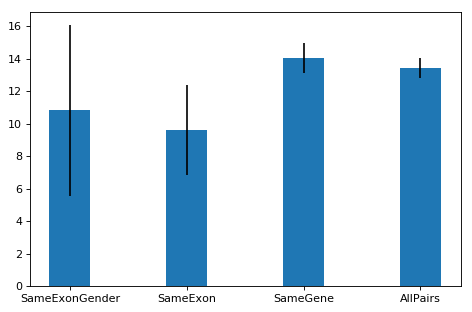

8 103


MannwhitneyuResult(statistic=306.0, pvalue=0.11442121443279052)

In [1000]:
ind = np.arange(4)  # the x locations for the groups
width = 0.35  # the width of the bars
fig, ax = plt.subplots(dpi=80)
rects = ax.bar(ind, Dat, width, yerr=Err,)
ax.set_ylabel('')
ax.set_title('')
ax.set_xticks(ind)
ax.set_xticklabels(["SameExonGender", "SameExon", "SameGene", "AllPairs"])
fig.tight_layout()
plt.xticks(rotation=0)
plt.show()
print(len(SameExon), len(SameGene))
scipy.stats.mannwhitneyu(SameExon, SameGene)
#print(abs(np.mean(SameExon)-np.mean(SameGene)))

In [978]:
Test = DFF[DFF["Cohort"]=="SSC"]
SameExon, SameExonSameGender, SameGene, ALLPairs = SameExonDef2(Test)

In [979]:
#Test = DFF[(DFF["Cohort"]=="VIP")&(DFF["genetic_status"]!="ASXL3")]
Test = DFF[(DFF["Cohort"]=="VIP")]
SameExon, SameExonSameGender, SameGene, ALLPairs = SameExonDef2(Test)
#print(SameExon, SameExonSameGender, SameGene, ALLPairs)

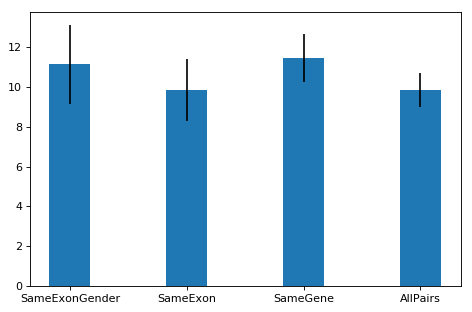

1.5984536512486809


In [980]:
Seq = [SameExonSameGender, SameExon, SameGene, ALLPairs]
Dat = [np.mean(x) for x in Seq]
Err = [np.std(x)/math.sqrt(len(x)) for x in Seq]
ind = np.arange(4)  # the x locations for the groups
width = 0.35  # the width of the bars
fig, ax = plt.subplots(dpi=80)
rects = ax.bar(ind, Dat, width, yerr=Err,)
ax.set_ylabel('')
ax.set_title('')
ax.set_xticks(ind)
ax.set_xticklabels(["SameExonGender", "SameExon", "SameGene", "AllPairs"])
fig.tight_layout()
plt.xticks(rotation=0)
plt.show()
scipy.stats.mannwhitneyu(SameExon, SameGene, alternative="less")
print(abs(np.mean(SameExon)-np.mean(SameGene)))

In [ ]:
Test = DFF[DFF["Cohort"]=="VIP"]
SameExon, SameExonSameGender, SameGene, ALLPairs = SameExonDef2(Test)
Seq = [SameExonSameGender, SameExon, SameGene, ALLPairs]
Dat = [np.mean(x) for x in Seq]
Err = [np.std(x)/math.sqrt(len(x)) for x in Seq]
ind = np.arange(4)  # the x locations for the groups
width = 0.35  # the width of the bars
fig, ax = plt.subplots(dpi=80)
rects = ax.bar(ind, Dat, width, yerr=Err,)
ax.set_ylabel('')
ax.set_title('')
ax.set_xticks(ind)
ax.set_xticklabels(["SameExonGender", "SameExon", "SameGene", "AllPairs"])
fig.tight_layout()
plt.xticks(rotation=0)
plt.show()
scipy.stats.mannwhitneyu(SameExon, SameGene, alternative="less")

In [940]:
print(len(SameExon))

38


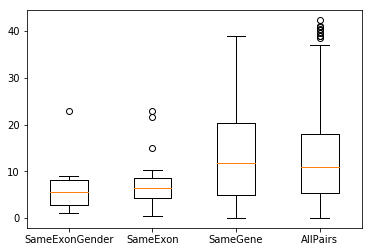

In [786]:
plt.boxplot([SameExonSameGender, SameExon, SameGene, ALLPairs],
            labels = ["SameExonGender", "SameExon", "SameGene", "AllPairs"])
plt.show()

In [1196]:
Andy_svip_vep = pd.read_csv("../data/Andy-VIP/svip_indiv_vep.txt", delimiter="\t")
Andy_svip_vep.head(3)

,Uploaded_variation,Location,Allele,Consequence,IMPACT,SYMBOL,Gene,Feature_type,Feature,BIOTYPE,...,PolyPhen,DOMAINS,HGVS_OFFSET,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,CADD_PHRED,CADD_RAW,BLOSUM62
0,15630-x2_PACS1_6,11:65978677-65978677,T,missense_variant,MODERATE,PACS1,ENSG00000175115,Transcript,ENST00000320580,protein_coding,...,probably_damaging(0.948),"hmmpanther:PTHR13280:SF16,hmmpanther:PTHR13280",-,-,-,-,-,35,7.635711,-3
1,15630-x2_PACS1_6,11:65978677-65978677,T,non_coding_transcript_exon_variant,MODIFIER,PACS1,ENSG00000175115,Transcript,ENST00000527224,retained_intron,...,-,-,-,-,-,-,-,35,7.635711,-
2,15630-x2_PACS1_6,11:65978677-65978677,T,missense_variant,MODERATE,PACS1,ENSG00000175115,Transcript,ENST00000527380,protein_coding,...,probably_damaging(0.986),"hmmpanther:PTHR13280,hmmpanther:PTHR13280:SF16",-,-,-,-,-,35,7.635711,-3


In [1197]:
#Andy_svip_vep = pd.read_csv("../data/Andy-VIP/svip_indiv_vep.tsv", delimiter="\t")
Andy_svip_vabs = pd.read_csv("../data/Andy-VIP/svip_vineland.csv")
Andy_lgd_bl = [x.strip() for x in open("../data/Andy-VIP/svip_indiv_noNMD.bl", 'rt')]

In [1198]:
Andy_svip_vep.head(2)

,Uploaded_variation,Location,Allele,Consequence,IMPACT,SYMBOL,Gene,Feature_type,Feature,BIOTYPE,...,PolyPhen,DOMAINS,HGVS_OFFSET,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,CADD_PHRED,CADD_RAW,BLOSUM62
0,15630-x2_PACS1_6,11:65978677-65978677,T,missense_variant,MODERATE,PACS1,ENSG00000175115,Transcript,ENST00000320580,protein_coding,...,probably_damaging(0.948),"hmmpanther:PTHR13280:SF16,hmmpanther:PTHR13280",-,-,-,-,-,35,7.635711,-3
1,15630-x2_PACS1_6,11:65978677-65978677,T,non_coding_transcript_exon_variant,MODIFIER,PACS1,ENSG00000175115,Transcript,ENST00000527224,retained_intron,...,-,-,-,-,-,-,-,35,7.635711,-


In [1199]:
Andy_svip_vabs.head(5)

,src,idx,sfari_id,relationship_to_iip,communication_standard,dls_standard,soc_standard,motor_skills_standard,composite_standard_score,age_at_eval
0,ADNP,1,15218-x1,Initially identified proband,57,55,51,NaN,54.0,131
1,ADNP,3,15229-x1,Initially identified proband,53,52,57,NaN,55.0,101
2,ADNP,4,15229-x1,Initially identified proband,53,51,57,NaN,54.0,111
3,ADNP,5,15229-x1,Initially identified proband,53,47,53,NaN,51.0,121
4,ADNP,6,15263-x1,Initially identified proband,30,28,40,NaN,29.0,216


In [1200]:
Andy_svip_vabs[Andy_svip_vabs["src"]=="FOXP1"]

,src,idx,sfari_id,relationship_to_iip,communication_standard,dls_standard,soc_standard,motor_skills_standard,composite_standard_score,age_at_eval
22,FOXP1,1,15206-x1,Initially identified proband,74,59,64,NaN,64.0,147
23,FOXP1,2,15206-x1,Initially identified proband,74,59,66,NaN,65.0,157
24,FOXP1,3,15206-x1,Initially identified proband,74,65,68,NaN,67.0,123
25,FOXP1,6,15289-x1,Initially identified proband,79,62,72,67.0,67.0,67
26,FOXP1,7,15289-x1,Initially identified proband,76,64,75,67.0,67.0,74
27,FOXP1,8,15289-x1,Initially identified proband,74,66,75,NaN,71.0,85
28,FOXP1,10,15930-x1,Initially identified proband,72,69,73,NaN,70.0,96


In [1201]:
DF.head(2)

,Cohort,composite_standard_score,genetic_status,inheritance_status,location,sex,sfari_id,Transcript,ProteinPos,GeneCount,Exons,isLEJ
0,SSC,53.0,ADNP,de-novo,20:49509094-49509094,M,13545,ENST00000396029,905,10,ENSE00001455631,T
1,SSC,67.0,ADNP,de-novo,20:49510027-49510029,F,12130,ENST00000396029,594,10,ENSE00001455631,T


In [911]:
Andy_IDs =set(Andy_svip_vabs["sfari_id"].values)
My_IDs = set(DF[DF["Cohort"]=="VIP"]["sfari_id"].values)

In [912]:
MyNotAndy = My_IDs.difference(Andy_IDs)

In [913]:
AndyNotMy = Andy_IDs.difference(My_IDs)

In [923]:
#Andy_svip_vabs[Andy_svip_vabs["sfari_id"].isin(AndyNotMy)]

In [916]:
#DF[DF["sfari_id"].isin(MyNotAndy)]

In [917]:
selectedTransNoVersionNumber = [x.split(".")[0] for x in selectedTrans]

In [918]:
selectedTransNoVersionNumber

['ENST00000269197',
 'ENST00000399982',
 'ENST00000339659',
 'ENST00000394196',
 'ENST00000357398',
 'ENST00000318789',
 'ENST00000367603',
 'ENST00000485511',
 'ENST00000418600',
 'ENST00000373302',
 'ENST00000320580',
 'ENST00000281928',
 'ENST00000361283',
 'ENST00000282030',
 'ENST00000217244',
 'ENST00000396029',
 'ENST00000400454',
 'ENST00000400454',
 'ENST00000609686']

In [1202]:
Andy_svip_vep2 = Andy_svip_vep[Andy_svip_vep["Feature"].isin(selectedTransNoVersionNumber)]

In [1203]:
Andy_svip_vep2["sfari_id"] = Andy_svip_vep2.apply(lambda row:row["Uploaded_variation"].split("_")[0], axis=1)
Andy_svip_vep2.head(5)

/Users/jiayao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Uploaded_variation,Location,Allele,Consequence,IMPACT,SYMBOL,Gene,Feature_type,Feature,BIOTYPE,...,DOMAINS,HGVS_OFFSET,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,CADD_PHRED,CADD_RAW,BLOSUM62,sfari_id
0,15630-x2_PACS1_6,11:65978677-65978677,T,missense_variant,MODERATE,PACS1,ENSG00000175115,Transcript,ENST00000320580,protein_coding,...,"hmmpanther:PTHR13280:SF16,hmmpanther:PTHR13280",-,-,-,-,-,35,7.635711,-3,15630-x2
5,15631-x2_PACS1_20,11:65978677-65978677,T,missense_variant,MODERATE,PACS1,ENSG00000175115,Transcript,ENST00000320580,protein_coding,...,"hmmpanther:PTHR13280:SF16,hmmpanther:PTHR13280",-,-,-,-,-,35,7.635711,-3,15631-x2
10,15632-x2_PACS1_7,11:65978677-65978677,T,missense_variant,MODERATE,PACS1,ENSG00000175115,Transcript,ENST00000320580,protein_coding,...,"hmmpanther:PTHR13280:SF16,hmmpanther:PTHR13280",-,-,-,-,-,35,7.635711,-3,15632-x2
15,15634-x2_PACS1_14,11:65978677-65978677,T,missense_variant,MODERATE,PACS1,ENSG00000175115,Transcript,ENST00000320580,protein_coding,...,"hmmpanther:PTHR13280:SF16,hmmpanther:PTHR13280",-,-,-,-,-,35,7.635711,-3,15634-x2
20,15635-x3_PACS1_24,11:65978677-65978677,T,missense_variant,MODERATE,PACS1,ENSG00000175115,Transcript,ENST00000320580,protein_coding,...,"hmmpanther:PTHR13280:SF16,hmmpanther:PTHR13280",-,-,-,-,-,35,7.635711,-3,15635-x3


In [1204]:
# Drop duplicates
sfari_id2vabs = {}
for i, row in Andy_svip_vabs.iterrows():
    sfari_id = row["sfari_id"]
    df = Andy_svip_vabs[Andy_svip_vabs["sfari_id"]==sfari_id]
    sfari_id2vabs[sfari_id] = np.mean(df["composite_standard_score"].values)
    Andy_svip_vabs.loc[i, "composite_standard_score"] = sfari_id2vabs[sfari_id]
Andy_svip_vabs = Andy_svip_vabs.drop_duplicates(subset="sfari_id",keep="first")


In [1205]:
#MatchUp VABS & Mutation
for i, row in Andy_svip_vabs.iterrows():
    sfari_id = row["sfari_id"]
    try:
        df = Andy_svip_vep2[Andy_svip_vep2["sfari_id"]==sfari_id]
        Andy_svip_vabs.loc[i, "Location"] = df["Location"].values[0]
        Andy_svip_vabs.loc[i, "Consequence"] = df["Consequence"].values[0]
        Andy_svip_vabs.loc[i, "SYMBOL"] = df["SYMBOL"].values[0]
        Andy_svip_vabs.loc[i, "Gene"] = df["Gene"].values[0]
        Andy_svip_vabs.loc[i, "Feature"] = df["Feature"].values[0]
    except:
        print(sfari_id)

15217-x1
15489-x1
15925-x1
15214-x1


In [1206]:
Andy_svip_vabs = Andy_svip_vabs[Andy_svip_vabs["Consequence"].isin(['frameshift_variant','splice_acceptor_variant',
 'splice_donor_variant', 'stop_gained'])]
#Andy_svip_vabs

In [1035]:
Andy_svip_vabs["Exons"] = ""
for i, row in Andy_svip_vabs.iterrows():
    famid, gene, location = row["sfari_id"], row["SYMBOL"], row["Location"]
    ExonIDs, islej = searchExon(gene, location, GTFTree, row["Feature"])
    Andy_svip_vabs.at[i, "Exons"] = ExonIDs
    Andy_svip_vabs.at[i, "isLEJ"] = islej

In [1210]:
#Andy_svip_vabs
Andy_svip_vabs.head(2)
Andy_svip_vabs["sex"] = 'M'
Andy_svip_vabs["genetic_status"] = Andy_svip_vabs['SYMBOL']

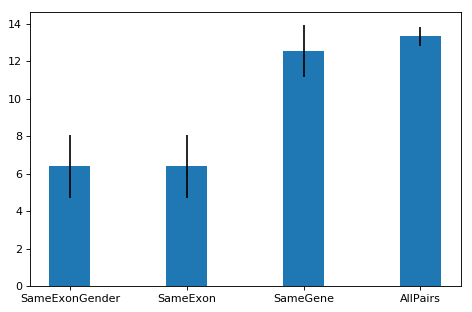

6.394557327389118 12.569125319619808


MannwhitneyuResult(statistic=101.0, pvalue=0.01825250487845501)

In [1054]:
Test = Andy_svip_vabs[Andy_svip_vabs["isLEJ"]=="F"]
SameExon, SameExonSameGender, SameGene, ALLPairs = SameExonDef1(Test)
Seq = [SameExonSameGender, SameExon, SameGene, ALLPairs]
Dat = [np.mean(x) for x in Seq]
Err = [np.std(x)/math.sqrt(len(x)) for x in Seq]
ind = np.arange(4)  # the x locations for the groups
width = 0.35  # the width of the bars
fig, ax = plt.subplots(dpi=80)
rects = ax.bar(ind, Dat, width, yerr=Err,)
ax.set_ylabel('')
ax.set_title('')
ax.set_xticks(ind)
ax.set_xticklabels(["SameExonGender", "SameExon", "SameGene", "AllPairs"])
fig.tight_layout()
plt.xticks(rotation=0)
plt.show()
print(np.mean(SameExon), np.mean(SameGene))
scipy.stats.mannwhitneyu(SameExon, SameGene, alternative="less")

In [1055]:
GTFTree4SSC = LoadGTF("unifiedmodel/RecLGDgenes.gencode.v19.gtf")
GTFTree4VIP = LoadGTF("unifiedmodel/VIPgenes.gencode.v19.gtf")
GTFTree = {}
for gene, geneobj in GTFTree4SSC.items():
    GTFTree[gene] = geneobj
for gene, geneobj in GTFTree4VIP.items():
    if gene not in GTFTree:
        GTFTree[gene] = geneobj

In [1208]:
RecGenes = ["ASXL3","CHD2","CHD8","DSCAM","DYRK1A","FOXP1","HIVEP2","SCN2A","ADNP","CHAMP1","CSNK2A1","GRIN2B",
        "HNRNPH2","MED13L","PACS1","PPP2R5D","SETBP1","STXBP1","SYNGAP1"]
Jiayao_features = pd.read_csv("unifiedmodel/features.jiayao.65.csv")
#df = Jiayao_features[Jiayao_features["effectGene"].isin(Genes)]
df = Jiayao_features
#display(df.head(2))
for i, row in df.iterrows():
    df.loc[i, "sfari_id"] = df.loc[i, "familyId"]
    df.loc[i, "sex"] = df.loc[i, "gender"]
    Chr, Pos, Ref, Alt = row["vcfVariant"].split(":")
    Len = max(0, len(Ref) - len(Alt))
    df.loc[i, "location"] = "{}:{}-{}".format(Chr, Pos, int(Pos)+Len)
    df.loc[i, "inheritance_status"] = "de-novo"
    df.loc[i, "genetic_status"] = row["effectGene"]
    df.loc[i, "composite_standard_score"] = row["VABS"]
    df.loc[i, "Cohort"] = "SSC"
#df.head(2)
df = df[["Cohort", "sfari_id","sex","genetic_status","inheritance_status","composite_standard_score","location"]]

In [1211]:
Andy_svip_vabs.head(2)
Andy_svip_vabs["sex"] = "M"
Andy_svip_vabs["inheritance_status"] = "de-novo"
Andy_svip_vabs["location"] = Andy_svip_vabs["Location"]
Andy_svip_vabs_ = Andy_svip_vabs[["sfari_id","sex","genetic_status",
                                   "inheritance_status","composite_standard_score","location"]]
Andy_svip_vabs_["Cohort"] = "VIP"

/Users/jiayao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [1212]:
VABS = pd.concat([df, Andy_svip_vabs_])
VABS = VABS[VABS["inheritance_status"]=="de-novo"]
#VABS = VABS.dropna()
VABS = VABS.reset_index(drop=True)

/Users/jiayao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [1213]:
VABS.to_csv("data/SVIP.V4.RecGenes.LGD.txt", index=False, sep="\t")

In [1064]:
DF = VABS

In [1065]:
DF.loc[DF["genetic_status"]=="MLL5", "genetic_status"] = "KMT2E" 
xxx = pd.read_csv("unifiedmodel/peptide-position-jy.csv")
xxx.loc[xxx["effectGene"]=="MLL5", "effectGene"] = "KMT2E" 
Gene2Trans2 = dict(zip(xxx["effectGene"].values, xxx["Transcript"].values))
display(DF.head(2))
Gene2Trans
Gene2Trans2
for i, row in DF.iterrows():
    if row["genetic_status"] in Gene2Trans:
        transcript = Gene2Trans[row["genetic_status"]]
    else:
        transcript = Gene2Trans2[row["genetic_status"]]
    DF.loc[i, "Transcript"] = transcript.split(".")[0]

,Cohort,composite_standard_score,genetic_status,inheritance_status,location,sex,sfari_id
0,SSC,53.0,ADNP,de-novo,20:49509094-49509094,M,13545
1,SSC,67.0,ADNP,de-novo,20:49510027-49510029,F,12130


In [1066]:
for i, row in DF.iterrows():
    #Chr, Pos, Ref, Alt = row["vcfVariant"].split(":")
    Chr, Pos = row["location"].split(":")
    Pos = int(Pos.split("-")[0])
    gene = row["genetic_status"]
    geneobj = GTFTree[gene]
    transobj = geneobj.Transcripts[row["Transcript"]]
    transobj.SortExons()
    varPos, TotalLength = searchAAPos(Pos, transobj)
    if varPos != "NA":
        DF.loc[i, "ProteinPos"] = str(int(varPos/3))
    else:
        DF.loc[i, "ProteinPos"] = str("NA")

In [1067]:
DF = DF[DF["ProteinPos"]!="NA"]
GeneCount = DF.groupby("genetic_status")["genetic_status"].count()
DF["GeneCount"] = DF.apply(lambda row: GeneCount[row["genetic_status"]], axis=1)
DF = DF[DF["GeneCount"]>=2]

In [1068]:
def searchExon(Gene, Location, GTFTree, Transcript):
    Chr, interval = Location.split(":")
    Start, End = interval.split("-")
    Pos, LenV = int(Start), int(End)-int(Start)
    gene_obj = GTFTree[Gene]
    _Exons = []
    #print(Location, Pos, LenV)
    islej = "F"
    transobj = gene_obj.Transcripts[Transcript]
    transobj.SortExons()
    for exon in transobj.ExonSeq:
        if Pos > exon.start -3 and Pos < exon.end +3:
            _Exons.append(exon.ExonID)
            break
        elif LenV > 0:
            if (Pos < exon.start-3 and Pos + LenV > exon.start ) or (Pos < exon.end and Pos + LenV > exon.end +3):
                _Exons.append(exon.ExonID)
                break
    if len(transobj.Exons) >= 2:
        interval1, interval2 = transobj.LastExonJunction()
        if (Pos > interval1[0] and Pos < interval1[1]):
            islej = "T"
        elif (Pos > interval2[0] and Pos < interval2[1]):
            islej = "T"
    if len(list(set(_Exons))) == 0:
        return "NA", "NA"
    else:
        return list(set(_Exons))[0], islej


DF["Exons"] = ""
for i, row in DF.iterrows():
    famid, gene, location = row["sfari_id"], row["genetic_status"], row["location"]
    ExonIDs, islej = searchExon(gene, location, GTFTree, row["Transcript"])
    DF.at[i, "Exons"] = ExonIDs
    DF.at[i, "isLEJ"] = islej

In [1071]:
DF

,Cohort,composite_standard_score,genetic_status,inheritance_status,location,sex,sfari_id,Transcript,ProteinPos,GeneCount,Exons,isLEJ
0,SSC,53.000000,ADNP,de-novo,20:49509094-49509094,M,13545,ENST00000396029,905,10,ENSE00001455631,T
1,SSC,67.000000,ADNP,de-novo,20:49510027-49510029,F,12130,ENST00000396029,594,10,ENSE00001455631,T
2,SSC,77.000000,ANK2,de-novo,4:114232545-114232545,M,12645,ENST00000357077,886,3,ENSE00003517727,F
3,SSC,88.000000,ANK2,de-novo,4:114251469-114251469,M,14256,ENST00000357077,980,3,ENSE00001695957,F
4,SSC,71.000000,ANK2,de-novo,4:114277599-114277600,M,13768,ENST00000357077,2595,3,ENSE00001003852,F
5,SSC,80.000000,ANKRD11,de-novo,16:89350771-89350775,M,12507,ENST00000301030,857,2,ENSE00003474344,F
6,SSC,76.000000,ANKRD11,de-novo,16:89351042-89351047,F,13905,ENST00000301030,767,2,ENSE00003474344,F
7,SSC,64.000000,ARID1B,de-novo,6:157510805-157510805,F,14393,ENST00000350026,1176,2,ENSE00001142078,F
8,SSC,58.000000,ARID1B,de-novo,6:157527664-157527668,F,13447,ENST00000350026,1777,2,ENSE00002020018,T
9,SSC,57.000000,CHD2,de-novo,15:93524060-93524064,F,13618,ENST00000394196,1288,3,ENSE00001097780,F


In [1069]:
res = {}
VABS2 = VABS[~VABS["sfari_id"].isin(["16159-x1", "16171-x1"])]
for gene in RecGenes:
    res[gene] = {}
    res[gene]["SameExon"] = []
    res[gene]["SameExonSameGender"] = []
    res[gene]["DiffExon"] = []
    #df = VABS2[VABS2["genetic_status"]==gene]
    df = DF[DF["genetic_status"]==gene]
    
    for row1, row2 in itertools.combinations(df.iterrows(), r=2):
        row1,row2 = row1[1], row2[1]
        score1 = row1["composite_standard_score"]
        score2 = row2["composite_standard_score"]
        if row1["Exons"] == row2["Exons"]:
            if row1["isLEJ"] == "T" or row2["isLEJ"] == "T":
                continue
            res[gene]["SameExon"].append( abs(score1-score2) )
            if row1["sex"] == row2["sex"]:
                res[gene]["SameExonSameGender"].append( abs(score1-score2) )
        else:
            res[gene]["DiffExon"].append( abs(score1-score2) )

In [1070]:
SameExonMeans, DiffExonMeans, SameExonSameGenderMeans, DiffExonMeans2 = [],[],[],[]
print("%20s\t%20s\t%s\t%s\t%s\t%s\t"%("SameExonVABSDiff", "NSameExonPair","SameExonSameGenderVABSDiff",
                                            "NSameExonSameGenderPair","SameGeneVABSDiff", "NSameGenePair"))
ExcludedGene = []
for gene in RecGenes:
    #if gene=="FOXP1":
    #    continue
    SameExon = res[gene]["SameExon"]
    SameExonSameGender = res[gene]["SameExonSameGender"]
    DiffExon = res[gene]["DiffExon"]
    if len(SameExon) == 0 or len(DiffExon) == 0:
        ExcludedGene.append(gene)
        continue
    SameExonMeans.append(np.mean(SameExon))
    DiffExonMeans.append(np.mean(DiffExon))
    if len(SameExonSameGender) != 0:
        SameExonSameGenderMeans.append(np.mean(SameExonSameGender))
        DiffExonMeans2.append(np.mean(DiffExon))
    print("%s\t%.2f\t%d\t%.2f\t%d\t%.2f\t%d"%(gene, np.mean(SameExon), len(SameExon), np.mean(SameExonSameGender), 
                                    len(SameExonSameGender), np.mean(DiffExon), len(DiffExon)))
print(SameExonMeans, DiffExonMeans)
print(scipy.stats.wilcoxon(SameExonMeans, DiffExonMeans))
print(scipy.stats.wilcoxon(SameExonSameGenderMeans, DiffExonMeans2))
print(ExcludedGene)

    SameExonVABSDiff	       NSameExonPair	SameExonSameGenderVABSDiff	NSameExonSameGenderPair	SameGeneVABSDiff	NSameGenePair	
ASXL3	6.00	3	6.00	3	10.53	9
CHD2	2.00	1	2.00	1	18.00	2
CHD8	11.00	1	nan	0	12.75	20
DSCAM	1.00	1	1.00	1	12.50	2
DYRK1A	0.00	1	0.00	1	19.80	5
FOXP1	7.36	3	7.36	3	6.99	3
HIVEP2	5.35	3	5.35	3	16.00	7
SCN2A	11.27	4	11.27	4	15.74	24
MED13L	3.00	1	3.00	1	15.96	9
[6.0, 2.0, 11.0, 1.0, 0.0, 7.35954884926079, 5.354166666666667, 11.265625, 3.0] [10.526922026621959, 18.0, 12.75, 12.5, 19.8, 6.986892242036272, 16.0, 15.7421875, 15.958333333333334]
WilcoxonResult(statistic=1.0, pvalue=0.010862224704815628)
WilcoxonResult(statistic=1.0, pvalue=0.017290280592906253)
['ADNP', 'CHAMP1', 'CSNK2A1', 'GRIN2B', 'HNRNPH2', 'PACS1', 'PPP2R5D', 'SETBP1', 'STXBP1', 'SYNGAP1']


/Users/jiayao/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/jiayao/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jiayao/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/Users/jiayao/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


In [1072]:
DF[DF["genetic_status"]=="MED13L"]

,Cohort,composite_standard_score,genetic_status,inheritance_status,location,sex,sfari_id,Transcript,ProteinPos,GeneCount,Exons,isLEJ
43,SSC,75.00000,MED13L,de-novo,12:116418553-116418553,M,12969,ENST00000281928,1780,5,ENSE00000918042,F
44,SSC,54.00000,MED13L,de-novo,12:116424952-116424952,M,14416,ENST00000281928,1352,5,ENSE00000835030,F
88,VIP,51.00000,MED13L,de-novo,12:116424952-116424952,M,15230-x1,ENST00000281928,1352,5,ENSE00000835030,F
89,VIP,48.34375,MED13L,de-novo,12:116413009-116413009,M,15240-x1,ENST00000281928,1891,5,ENSE00000835023,F
90,VIP,71.00000,MED13L,de-novo,12:116434362-116434366,M,15629-x2,ENST00000281928,966,5,ENSE00001003522,F


In [10]:
X = []
Y = []
for i in range(100):
    y1 = random.randint(0,100)
    y2 = random.randint(0,100)
    x = random.random()
    Y.append([y1, y2])
    X.append(x)

In [14]:
print(pearsonr(X, [abs(y1-y2) for (y1, y2) in Y]))
print(pearsonr(X, [abs(y1-y2)/x for (y1, y2), x in zip(Y,X)]))
print(pearsonr(X, [abs(y1/x-y2/x) for (y1, y2), x in zip(Y,X)]))

(0.03650821430771358, 0.7183892093911008)
(-0.370312842342934, 0.00014924795095448473)
(-0.370312842342934, 0.00014924795095448473)
